# Imports
Import libraries and any data or parameters needed for the project.

In [2]:
# Data Setup / Imports
from magrec import __logpath__, __datapath__

from copy import deepcopy
import inspect  # to print source code of a function


import numpy as np
import pandas as pd
import pyvista as pv
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F

import tqdm

import pytorch_lightning as L

from magrec.nn.modules import GaussianFourierFeaturesTransform, UniformFourierFeaturesTransform, RegularFourierFeaturesTransform
from magrec.nn.models import FourierFeaturesNd, WireNet
from magrec.nn.utils import batched_curl, batched_div, batched_grad, save_model_for_experiment, load_model_for_experiment

from magrec.misc.data import MagneticFieldUnstructuredGrid

from magrec.misc.plot import plot_n_components, plot_vector_field_2d, plot_check_aligned_data
from magrec.prop.constants import twopi
from magrec.prop.Propagator import CurrentPropagator2d

from magrec.misc.sampler import GridSampler, NDGridPoints
from magrec.nn.utils import rotate_vector_field_2d, get_ckpt_path_by_regexp, load_model_from_ckpt, plot_ffs_params, \
    reshape_rect
    
import k3d
import vedo
vedo.settings.default_backend= "k3d"

from magrec.nn.experiments import (
    ExperimentConfig,
    JerschowExperiment, 
    JerschowExperimentConfig, 
    JerschowExperimentDenoise, 
    JerschowExperimentLearnB,
    JerschowExperimentLearnDecayB,
    JerschowExperimentLearnBRandomPts,
    )

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


# Common functions and data loading

# Jerschow — Reconstruct current

 

In [5]:
model = load_model_from_ckpt(version_n=26, ckpt_name_regexp='last', folder_name='jerschow', type='ff_std_cond')

units = {
    "length": "mm",
    "magnetic_field": "nT",
    "current": "mA"
}

nx = 300
ny = 300
dx = 2.0
dy = 2.0
height = 12.0
layer_thickness = 0.4

rect = {
    "origin": [0, 0],
    "diagonal": [3, 3],
    "nx": nx,
    "ny": ny,
    "dx": dx,
    "dy": dy,
}

rect = reshape_rect(rect, origin=(-4, -4), diagonal=(4, 4))

prop = CurrentPropagator2d(
    source_shape=(rect["nx"], rect["ny"]),
    dx=rect["dx"],
    dy=rect["dy"],
    height=height,
    layer_thickness=layer_thickness,
    real_signal=False,
    units=units
)

pts = GridSampler.sample_grid(rect["nx"], rect["ny"], origin=rect["origin"], diagonal=rect["diagonal"])
pts.requires_grad_(True)
y_hat = model(pts).detach()
y_hat_grid = GridSampler.pts_to_grid(y_hat, rect["nx"], rect["ny"])

flow_fig = plot_vector_field_2d(y_hat_grid, cmap="plasma", units=r"{}/{}$^2$".format(units["current"], units["length"]))

values_hat = prop(y_hat_grid).real
mag_fig = plot_n_components(
    values_hat,
    labels=[r"B_x", r"B_y", r"B_z", r"B_{NV}"],
    cmap="bwr",
    units=units["magnetic_field"]
)

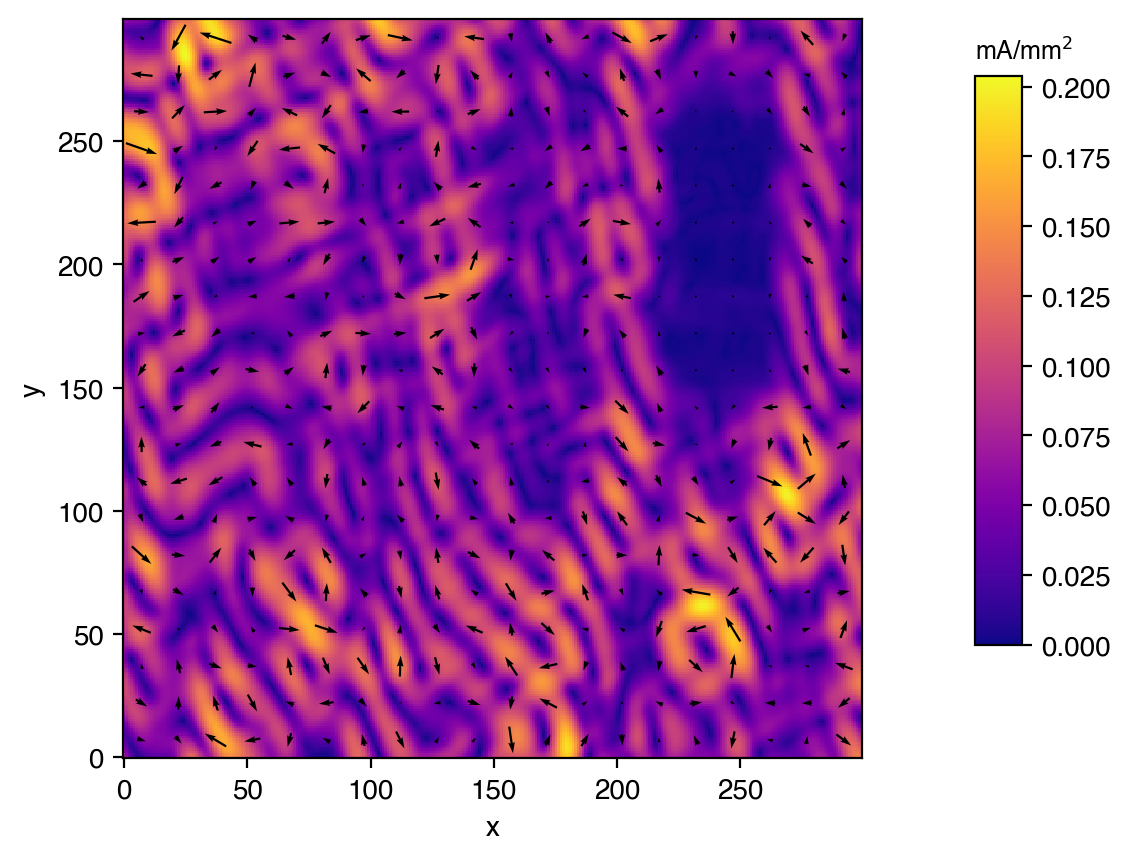

In [6]:
flow_fig

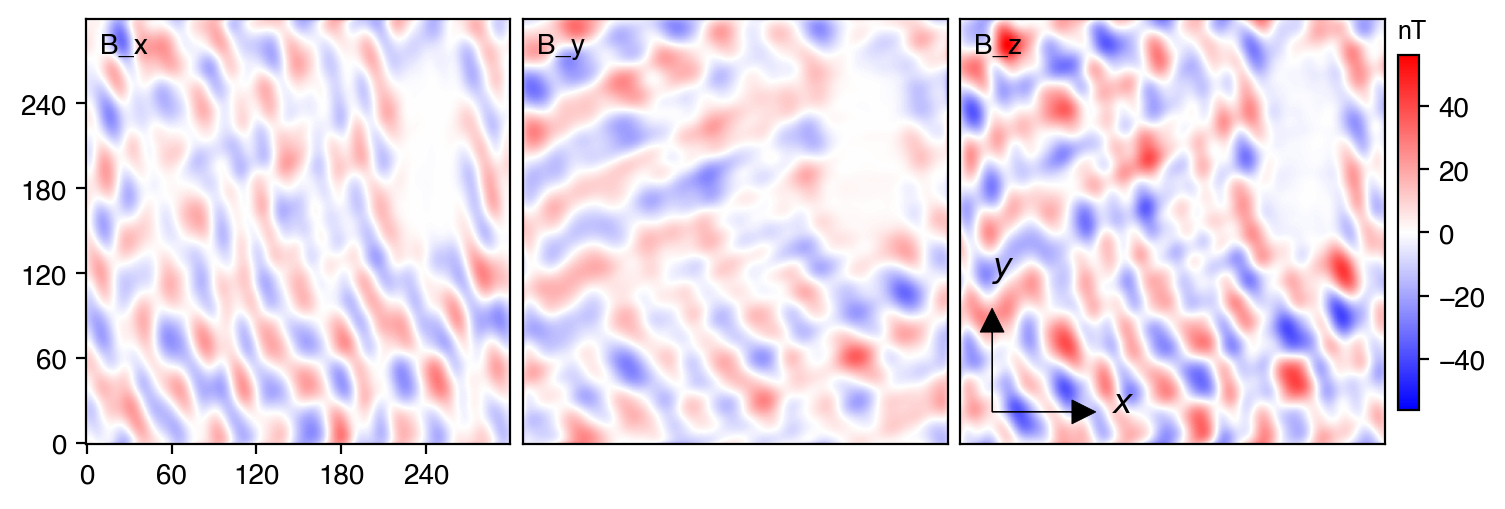

In [7]:
mag_fig

# Jerschow — Learn magnetic field

Goal of this section is to make a neural network $u_{NN}(x, y) = \vec{B}(x, y)$ that learns parameters given a set of measurement $N$ values $\{B^i_{NV}\}_{i = 1, \dots, N}$ obtained for a single component of the magnetic field $B_{NV}$ at different points ${(x_i, y_i)}_{i = 1, \dots, N}$

For this, we take any architecture of the neural network. 

We implement sampling of coordinates on a grid in a rectangle. There are two types of points: those with measurement values and those without. Those with measurement values should have corresponding values of the field. Those without can still be sampled to enforce additional constraints, besides the experimental data constraints. Such constraints, in the case of the magnetic field, are $\nabla\cdot\vec{B} = 0$ and $\nabla \times \vec{B} = 0$. 

## Neural network architecture

We have two neural networks to try. 

1. One learnes a mapping $(x, y, z) \mapsto \vec{B}(x, y, z)$ and receives the constraint $\nabla\cdot\vec{B} = 0$ together with $\nabla\times\vec{B} = 0$ as an additional loss term. 

2. The other learns a mapping $(x, y) \mapsto \vec{B}(x, y)$ and outputs a 2D vector field already free from divergence by construction.

Beyond that, there are also other approaches:

3. Use a neural network to learn a mapping $(x, y) \mapsto \vec{J}(x, y)$, again with the constraint $\nabla\cdot\vec{J} = 0$ either enforced by construction or as an additional loss term. Then, integrate the current to obtain the magnetic field.

4. We can also do all of the above directly in the Fourier space.

Below let's implement the first approach.

## Data to learn

What data should we try to learn? Let's start with a squiggly wire from Jerschow's dataset.

## GaussianFourierFeatures model

In [3]:
config = JerschowExperimentConfig('Sine_wire.txt',
                                  model_params=dict(n_inputs=3, n_outputs=3, 
                                                    ff_stds=[(0.1, 10), (2, 5), (5, 5)]),
                                  data_batch_size=1000,
                                  batch_size=1000,
                                  lr=1e-2,
                                  nz_points=100,
                                  eps_curl=1,
                                  eps_data=1,
                                  eps_div=1,)

experiment = JerschowExperimentLearnBRandomPts(config)

In [4]:
experiment.load_data()

In [45]:
experiment.train(n_iters=100000)

100%|██████████| 100000/100000 [35:16<00:00, 47.24it/s] 


In [5]:
# save_model_for_experiment(experiment, __datapath__ / "model_state_dict.pt") 
experiment = load_model_for_experiment(experiment, __datapath__ / "model_state_dict.pt")

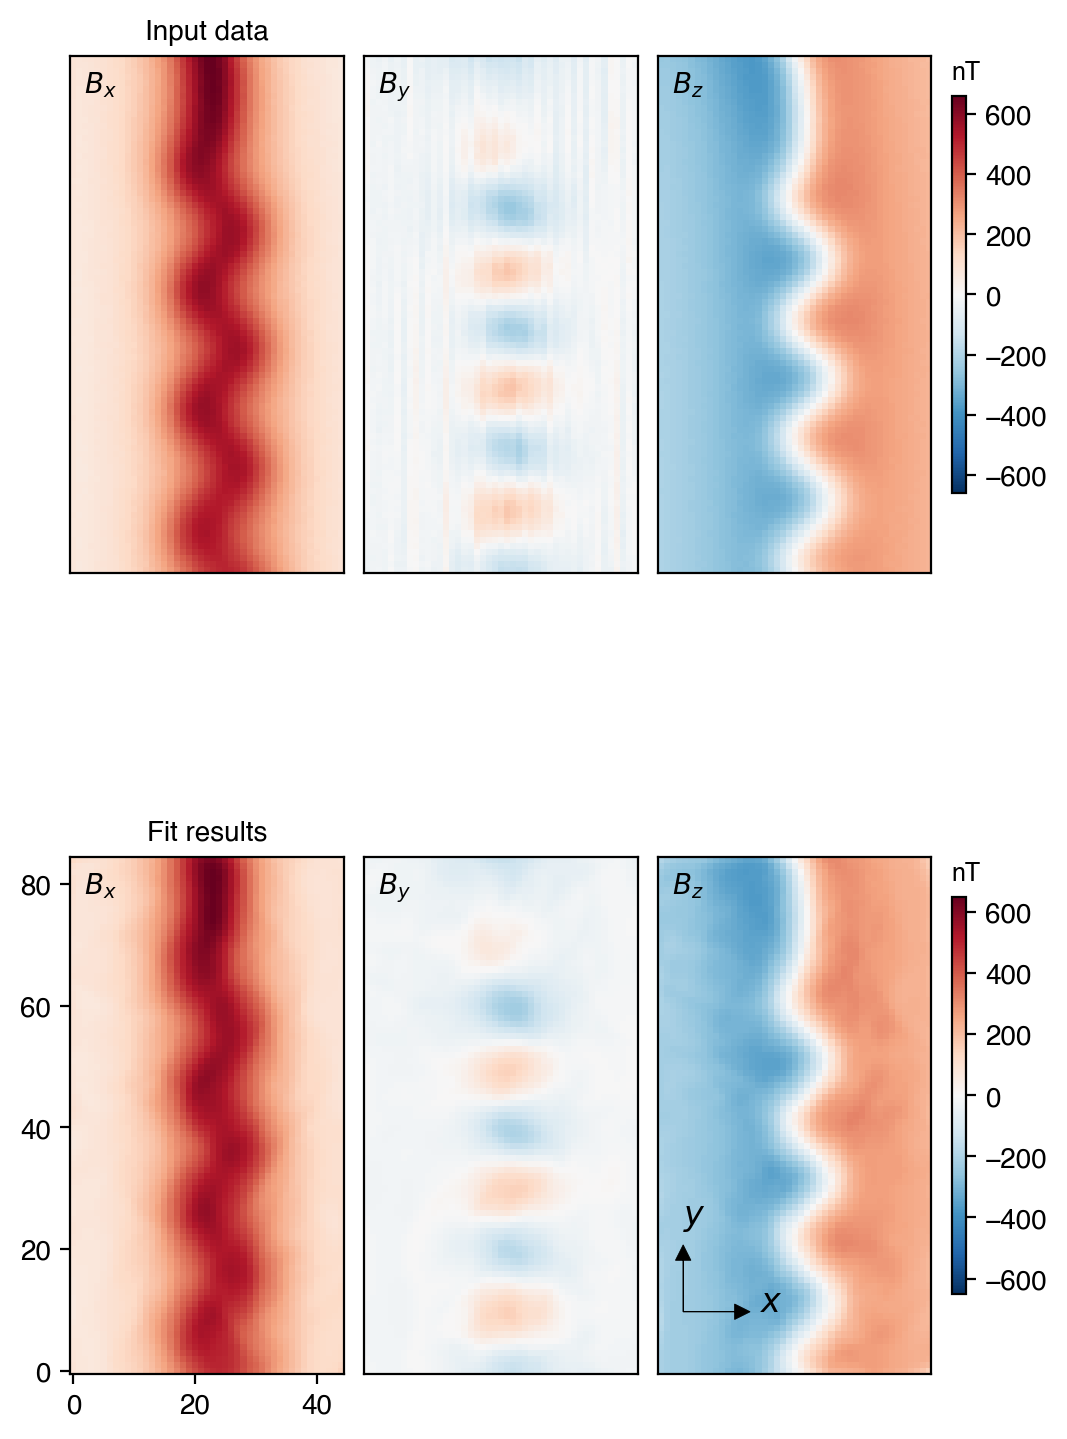

In [6]:
experiment.plot_results()

The results are not good. Is this due to the frequencies chosen? 

<Axes: >

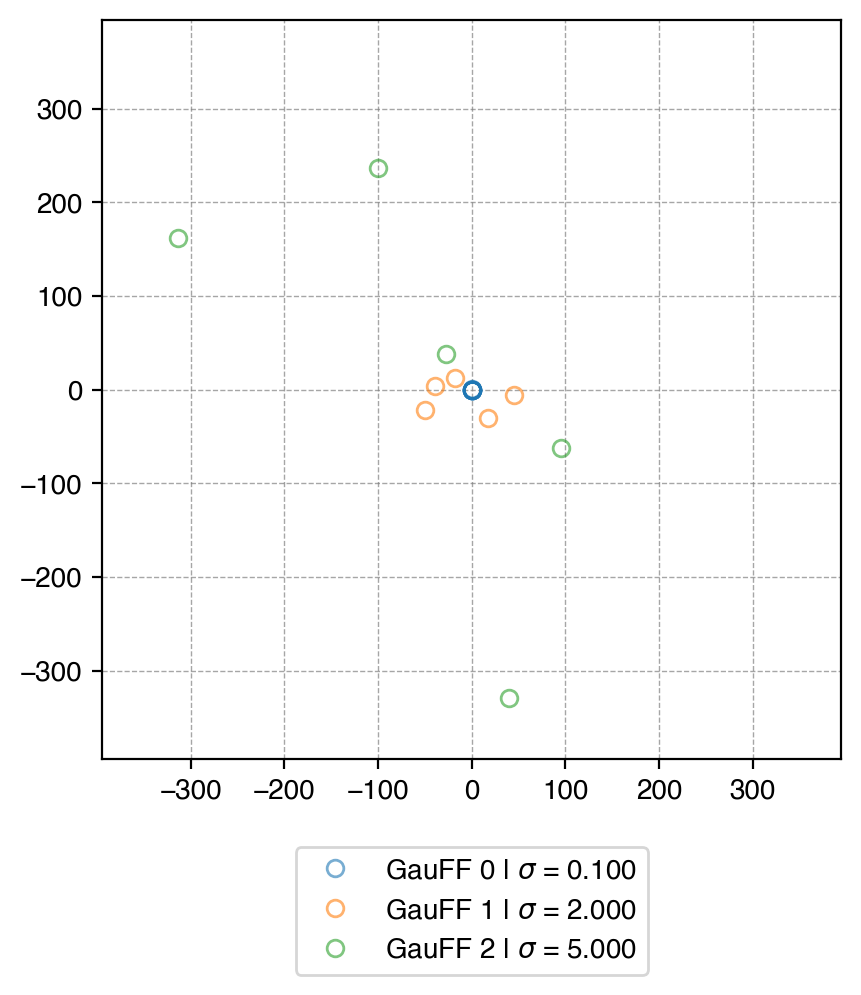

In [60]:
plot_ffs_params(experiment.model)

In [8]:
# Extract the B vectors from the experiment model
B_vectors = experiment.model.get_ffs_as_vectors()

In [75]:
np.array([[0, 0, 0],
              [2, 3, 4]]).astype(np.float32).shape

(2, 3)

In [ ]:
# Create a 3D plot using k3d
vectors = k3d.vectors(torch.zeros_like(B_vectors), B_vectors, color=0x0000ff)
plot = k3d.plot()
plot += vectors
plot.display()

Output()

<Axes: >

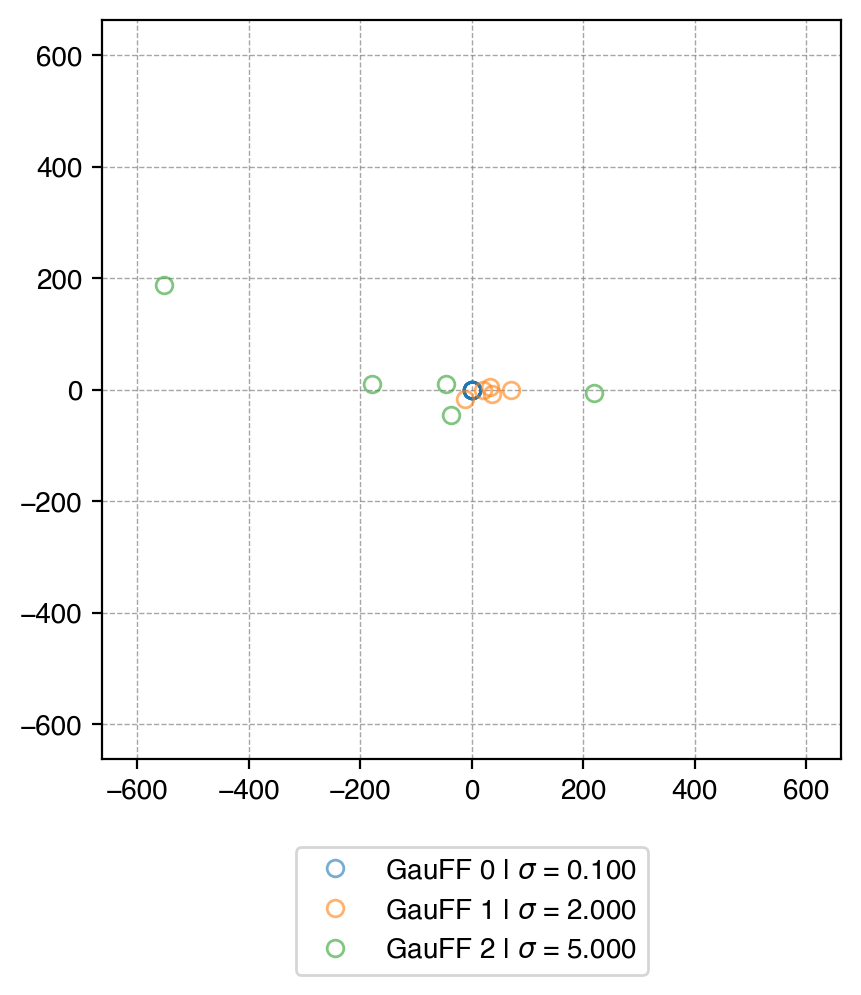

In [48]:
plot_ffs_params(experiment.model)

Let's save the results of the training, since they are not so bad. In fact, we have cleaned some systematic errors and got rid of the stripes. However, we introduced some inhomogeneous patches. Especially so in $B_z$ image. 

In [16]:
# save_model_for_experiment(experiment, __datapath__ / 'model_state_dict_GauFF.pt')

To load the trained model, we may create a clean config and run the code below to propagate the parameters from the file:

In [17]:
# that's a good model here, trained like below:
experiment_test = load_model_for_experiment(experiment, __datapath__ / 'model_state_dict_GauFF.pt')

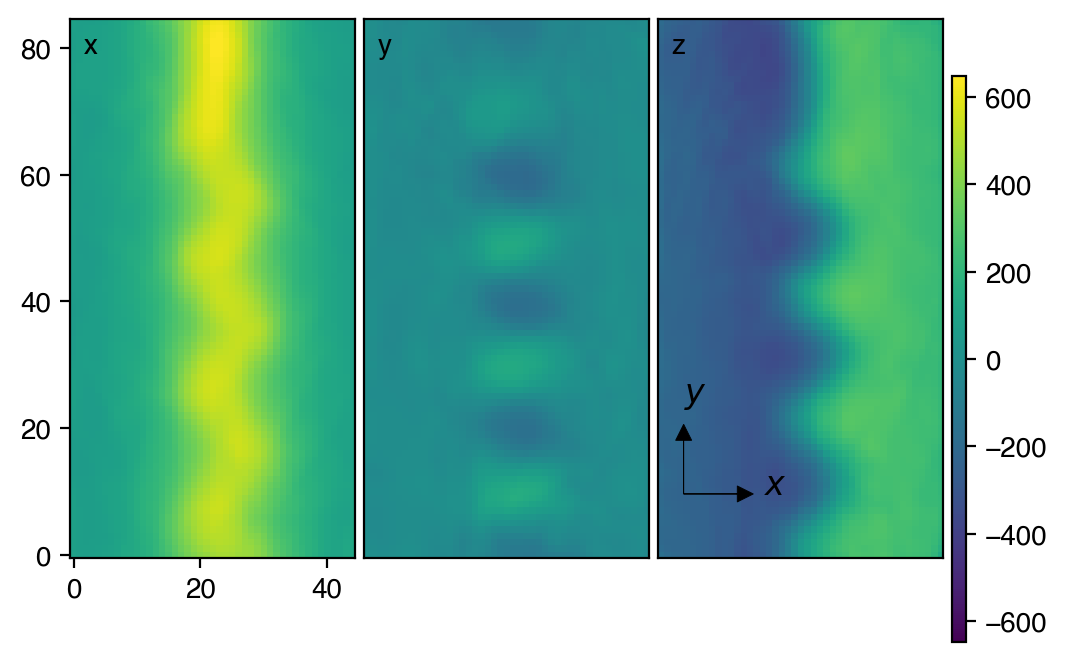

In [18]:
try:
    plot_n_components(experiment_test.config.data.get_as_grid("B_fit"))
except AttributeError:
    experiment_test.config.data.map(experiment_test.model, "B_fit")

plot_n_components(experiment_test.config.data.get_as_grid("B_fit"))

In [19]:
experiment_test.config.data

MagneticFieldImageData (0x34cf010c0)
  N Cells:      3696
  N Points:     3825
  X Bounds:     0.000e+00, 8.800e+01
  Y Bounds:     0.000e+00, 1.680e+02
  Z Bounds:     0.000e+00, 0.000e+00
  Dimensions:   45, 85, 1
  Spacing:      2.000e+00, 2.000e+00, 1.000e+00
  N Arrays:     2

In [23]:
expanded = experiment_test.config.data.expand_bounds_2d(1)

In [24]:
expanded

MultiBlock (0x3480e5300)
  N Blocks    2
  X Bounds    -90.000, 178.000
  Y Bounds    -170.000, 338.000
  Z Bounds    0.000, 0.000

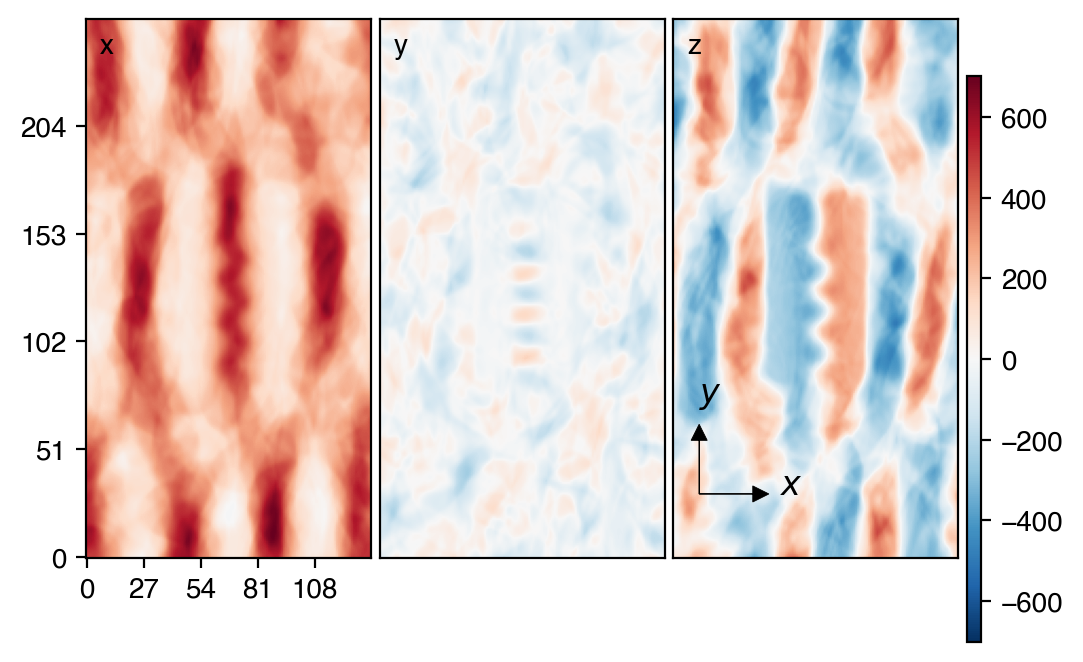

In [25]:
expanded[1].map(experiment_test.model, "B_fit")
plot_n_components(expanded[1].get_as_grid("B_fit"), cmap="RdBu_r")

Now we want to try the same training but with with different (or at least controller) Fourier features frequencies. Let's first see what frequencies has been randomly generated by the model.

<Axes: >

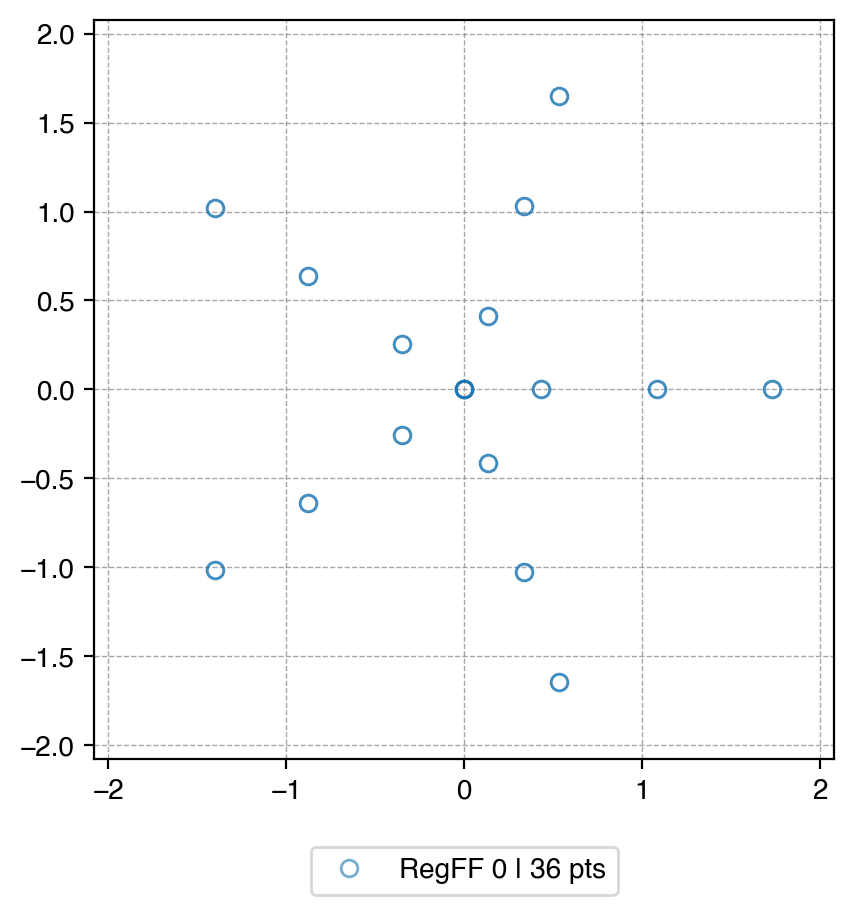

In [62]:
plot_ffs_params(RegularFourierFeaturesTransform(3, r_in=0.5, r_out=2, r_res=3, c_res=(6, 4)))

The model has been initialized with new params.


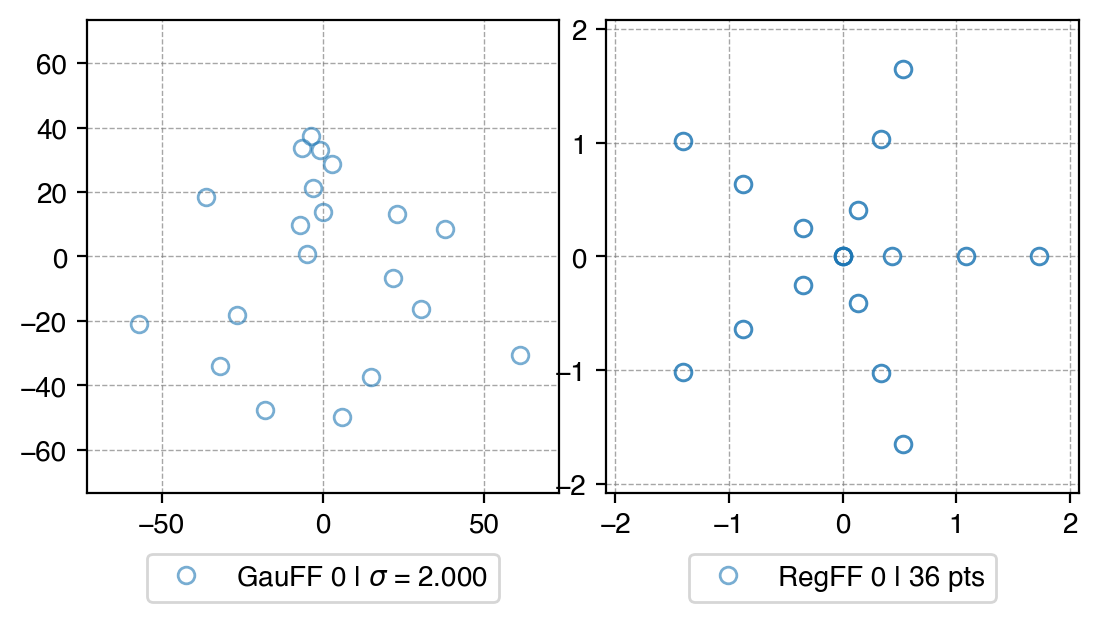

If reinitializing the trained model is not intended, press undo.


Button(description='Undo', style=ButtonStyle())

Output()

In [66]:
experiment.model.set_ffs(RegularFourierFeaturesTransform(3, r_in=0.5, r_out=2, r_res=3, c_res=(6, 4)), verbose=True)

Exception ignored in: <function PolyData.__del__ at 0x17be55240>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/currec/lib/python3.10/site-packages/pyvista/core/pointset.py", line 1693, in __del__
    del self._obbTree
AttributeError: _obbTree
Exception ignored in: <function PolyData.__del__ at 0x17be55240>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/currec/lib/python3.10/site-packages/pyvista/core/pointset.py", line 1693, in __del__
    del self._obbTree
AttributeError: _obbTree
  0%|          | 276/100000 [00:05<31:43, 52.38it/s]


Training interrupted.


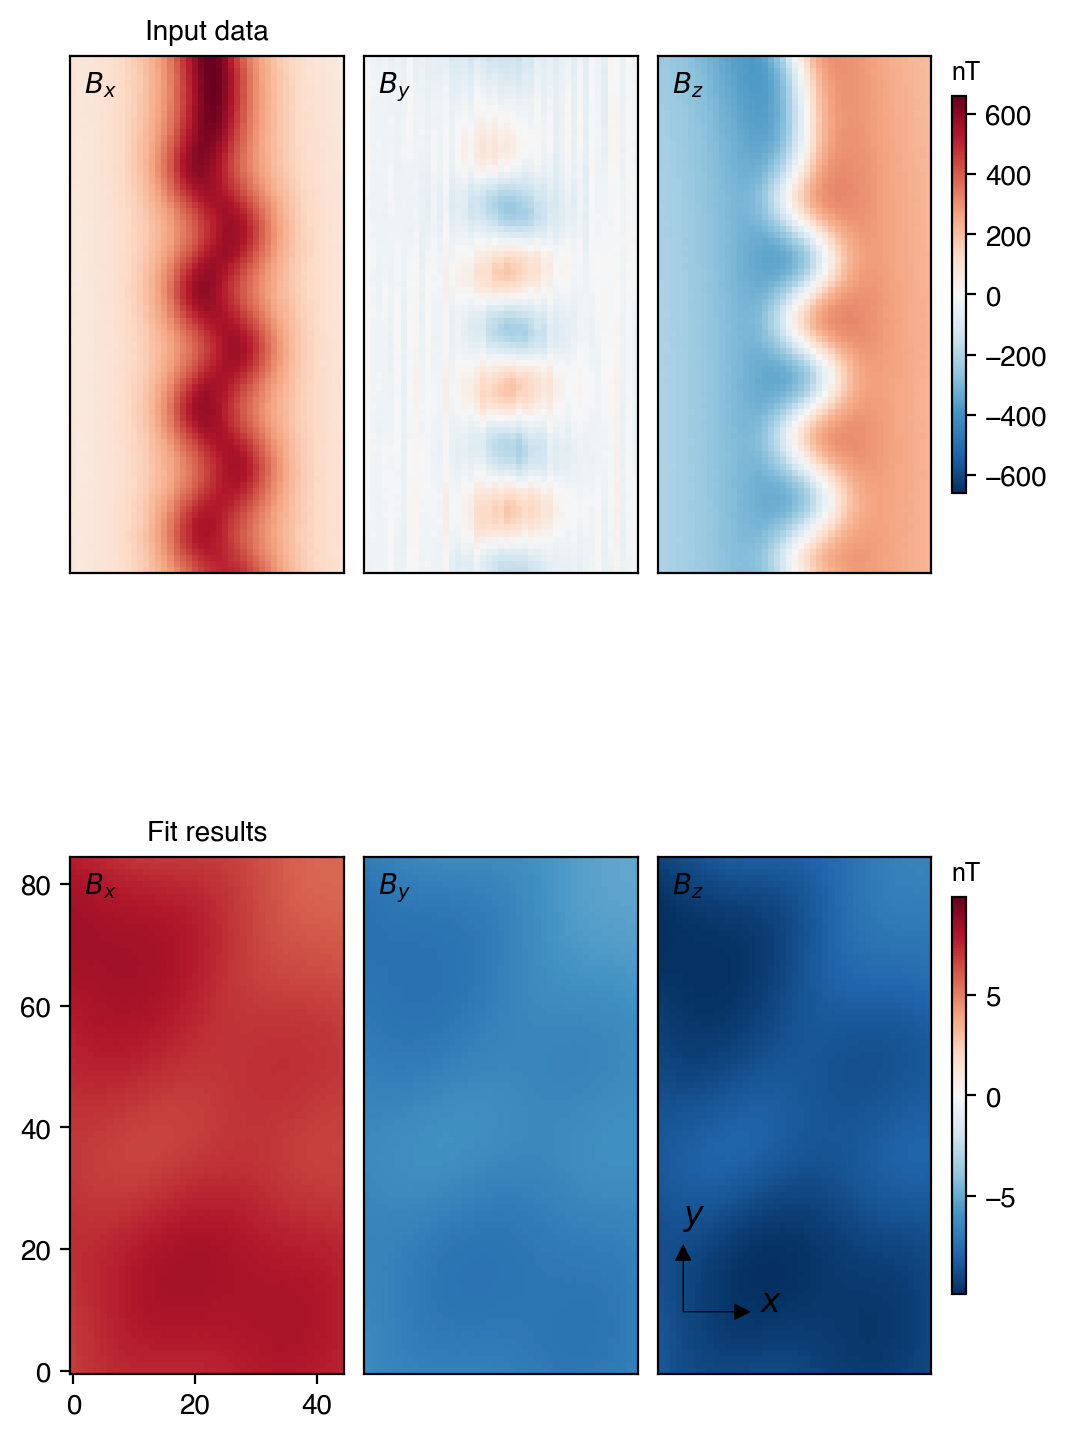

In [14]:
config = JerschowExperimentConfig('Sine_wire.txt',
                                  model_params=dict(n_inputs=3, n_outputs=3, 
                                                    ff_stds=[(0.1, 10), (2, 5), (3, 5)]),
                                  data_batch_size=1000,
                                  batch_size=1000,
                                  lr=1e-2,
                                  nz_points=100,
                                  eps_curl=1,
                                  eps_data=1,
                                  eps_div=1,)

experiment = JerschowExperimentLearnBRandomPts(config)
experiment.load_data()

experiment.train(n_iters=100000)
experiment.plot_results()

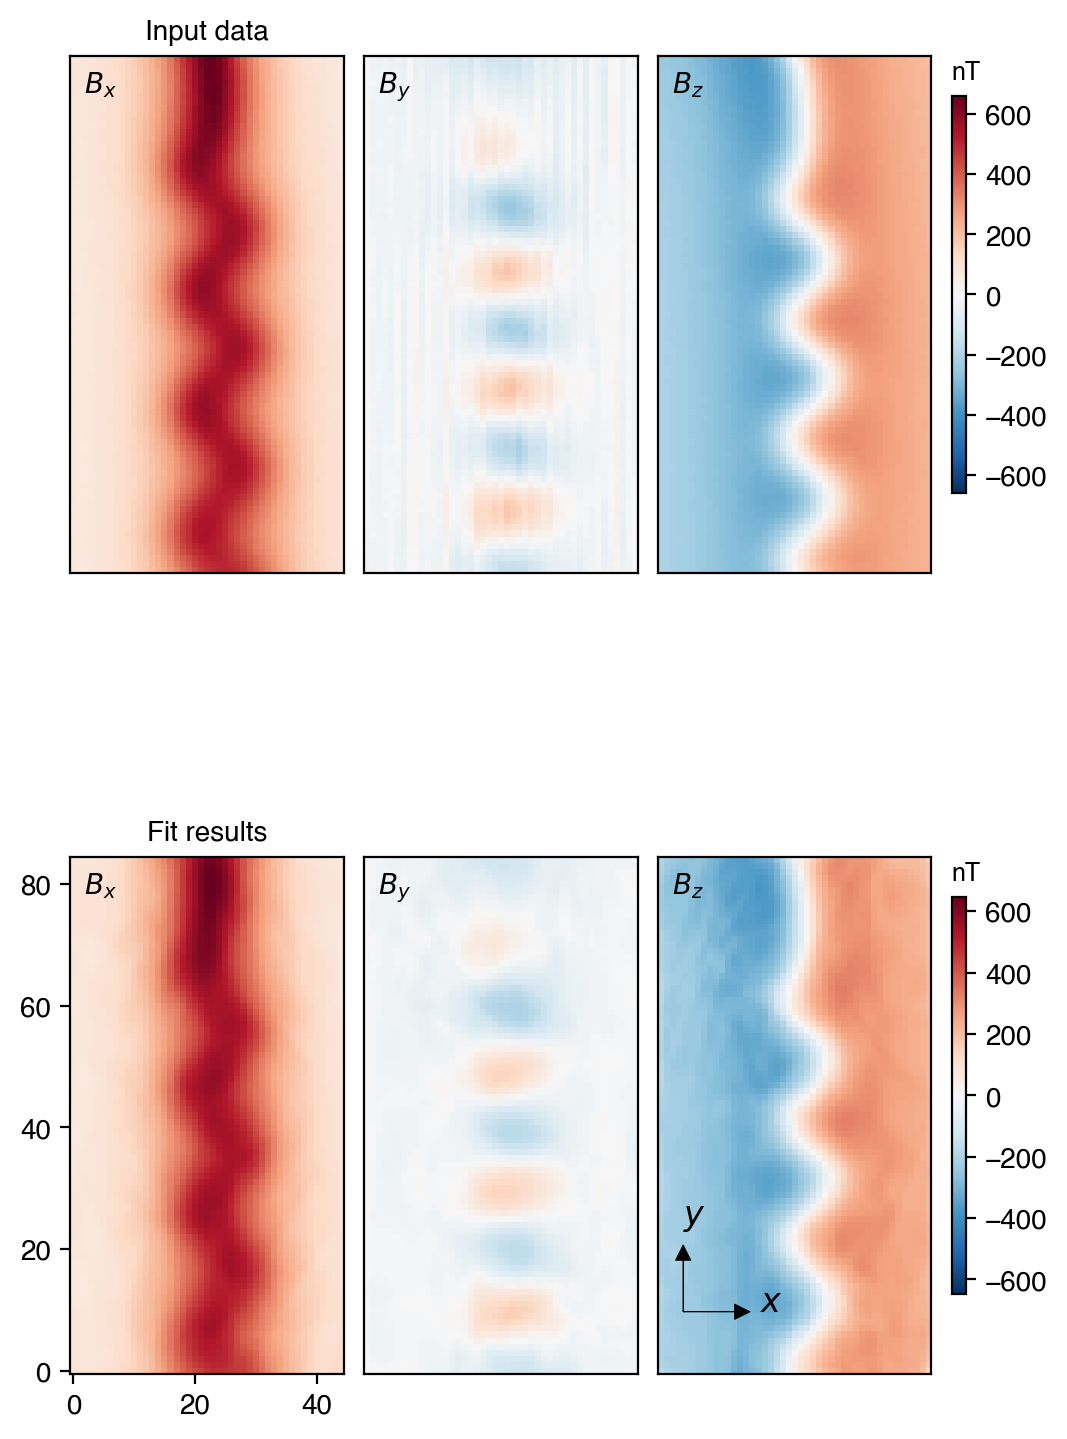

In [62]:
experiment_test.plot_results()

<Axes: >

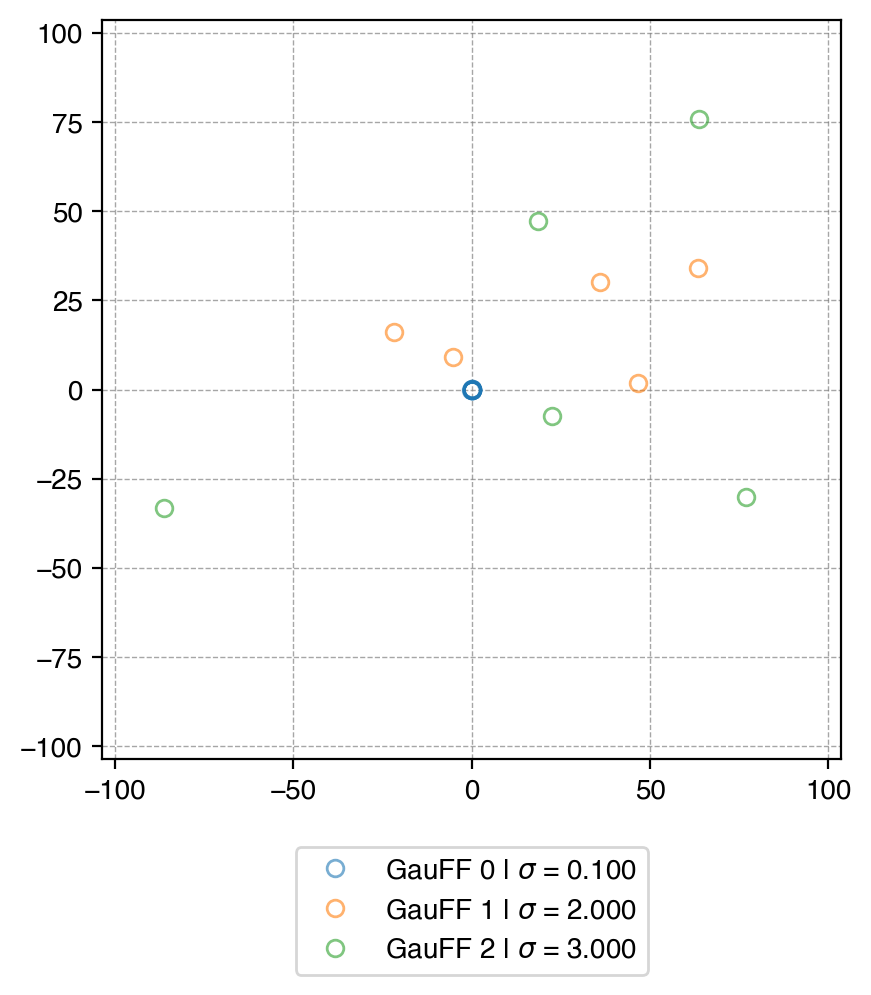

In [61]:
plot_ffs_params(experiment.model)

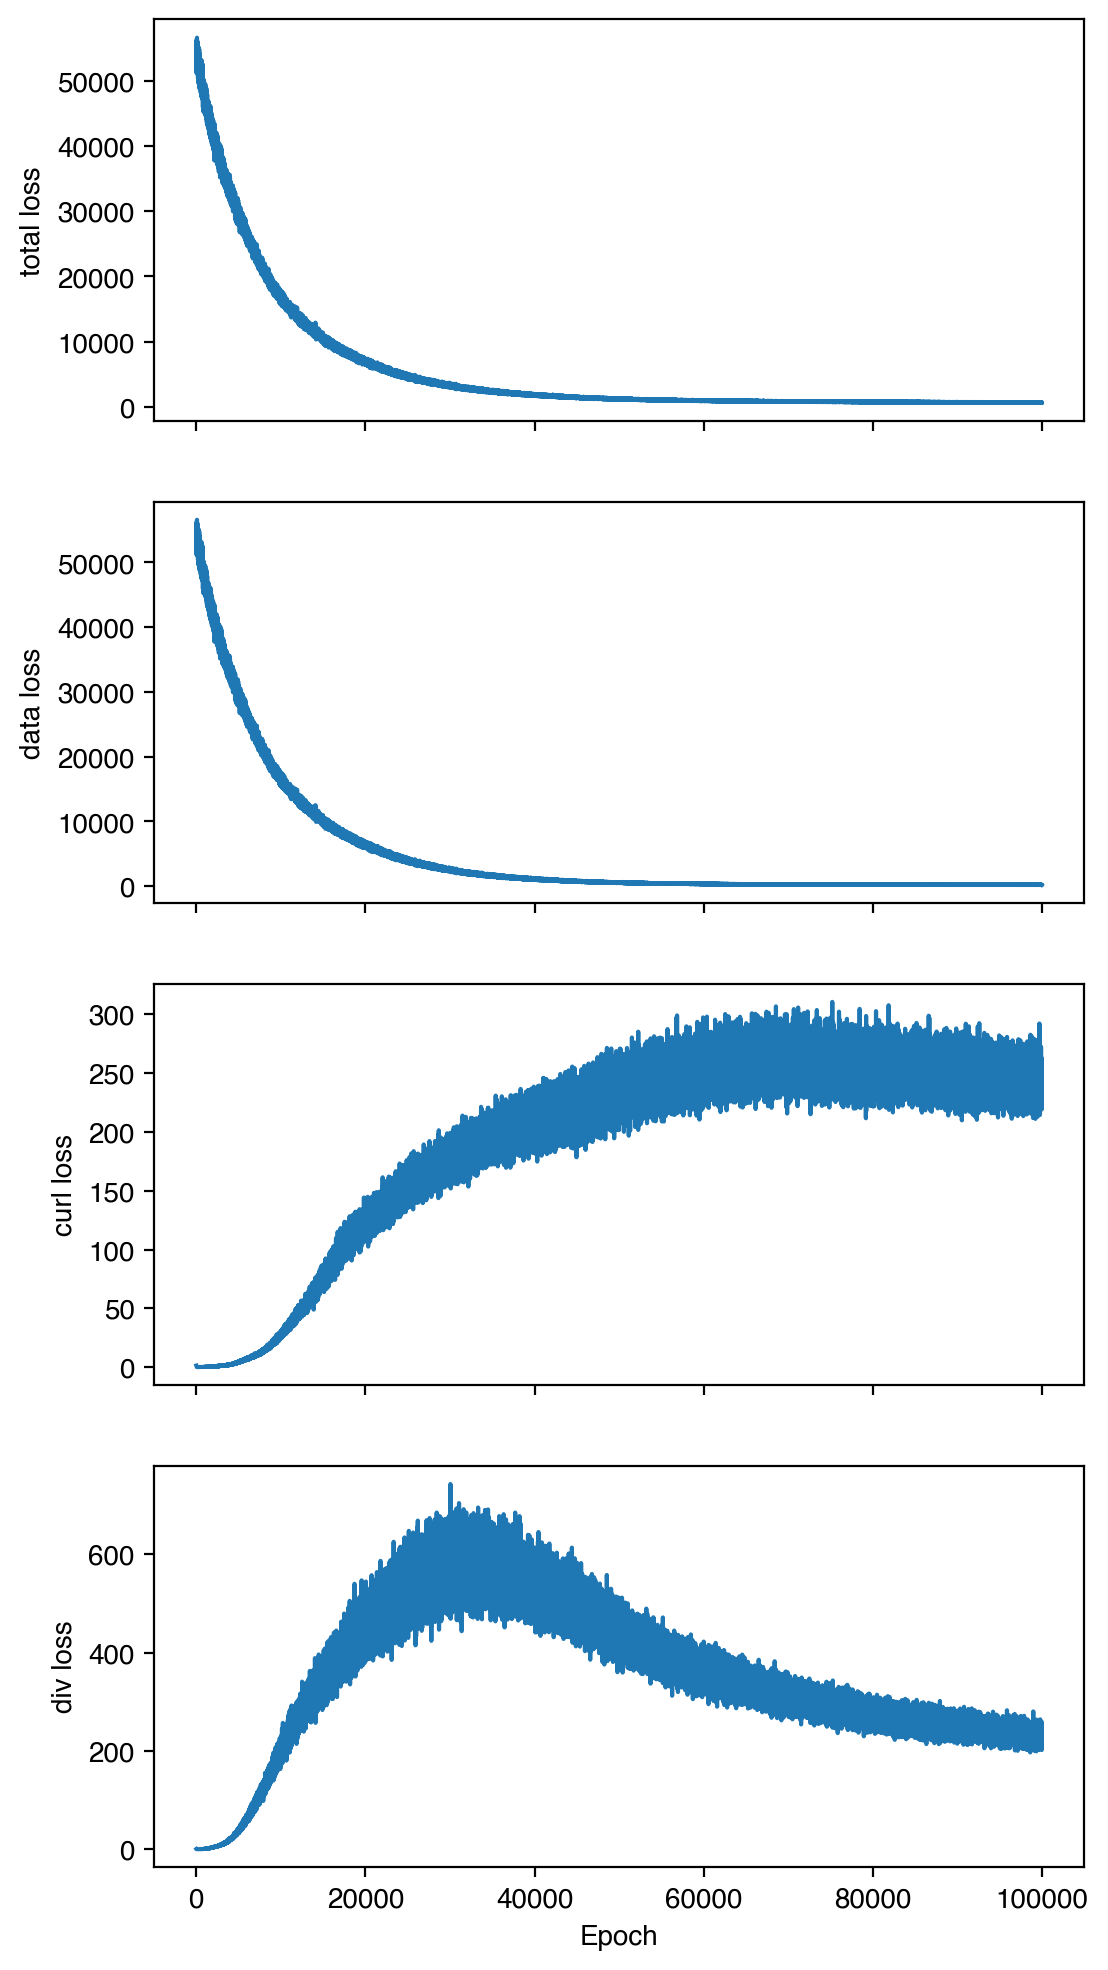

In [63]:
experiment.plot_losses()

100%|██████████| 100000/100000 [51:50<00:00, 32.15it/s]   


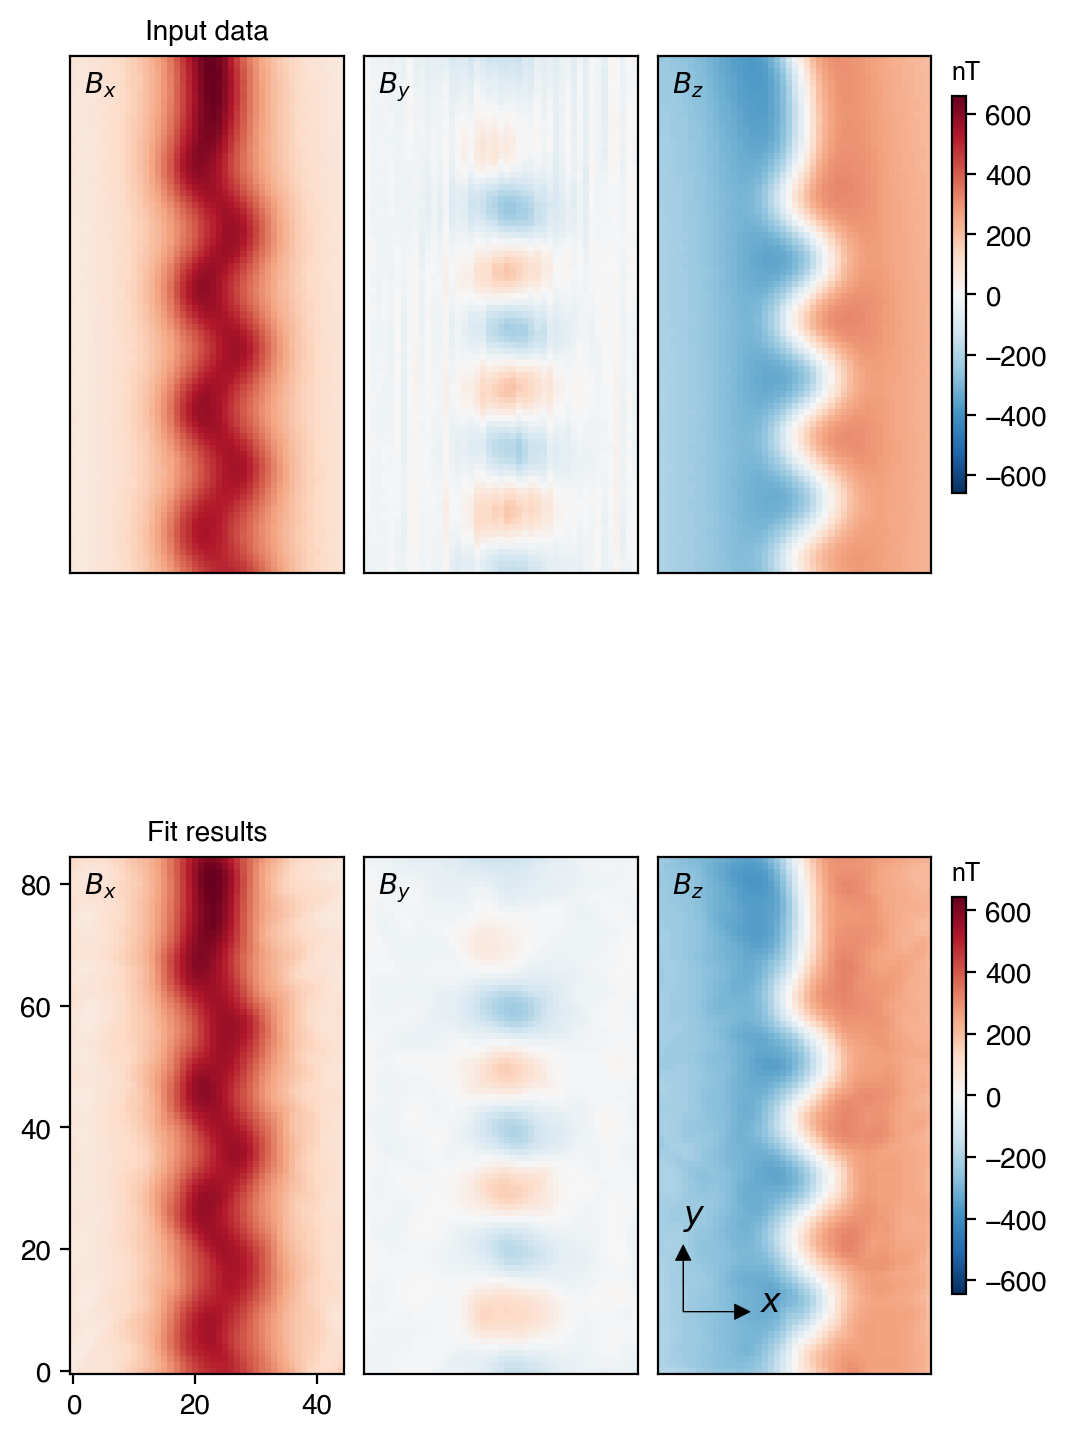

In [64]:
experiment.train(n_iters=100000)
experiment.plot_results()

In [13]:
experiment.is_trained = True
# save_model_for_experiment(experiment, path_to_model_dict=__datapath__ / "the_best_model_2.pt")
experiment = load_model_for_experiment(experiment, path_to_model_dict=__datapath__ / "the_best_model_1.pt")

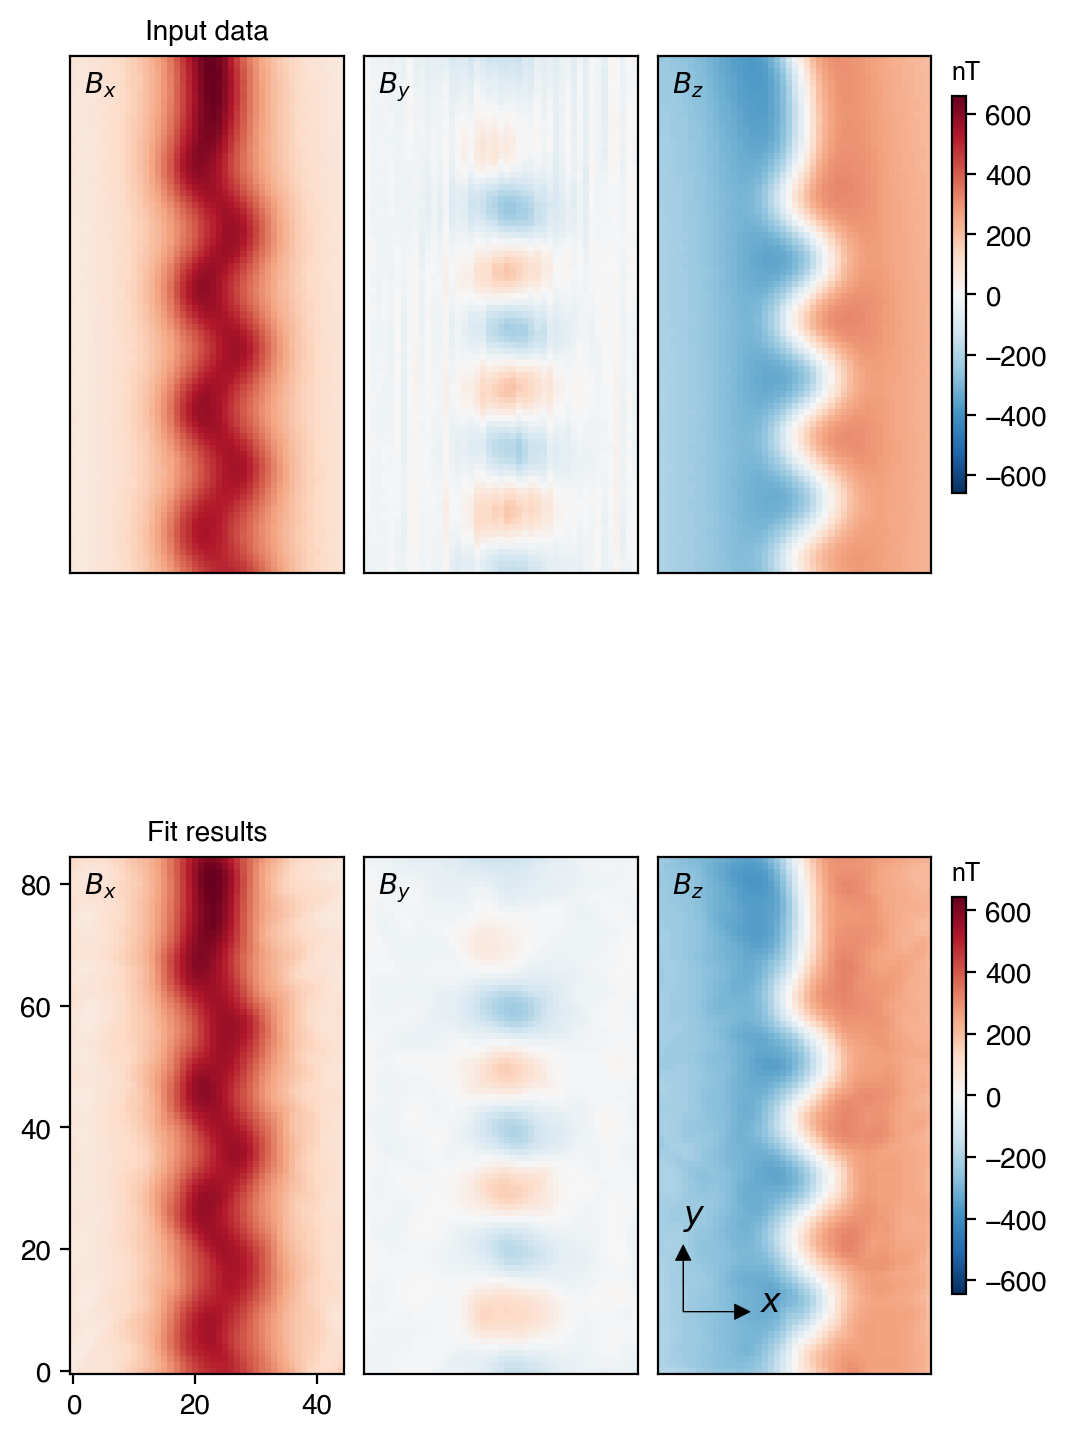

In [14]:
experiment.plot_results()

## What doesn't work

100%|██████████| 100000/100000 [18:02<00:00, 92.36it/s]


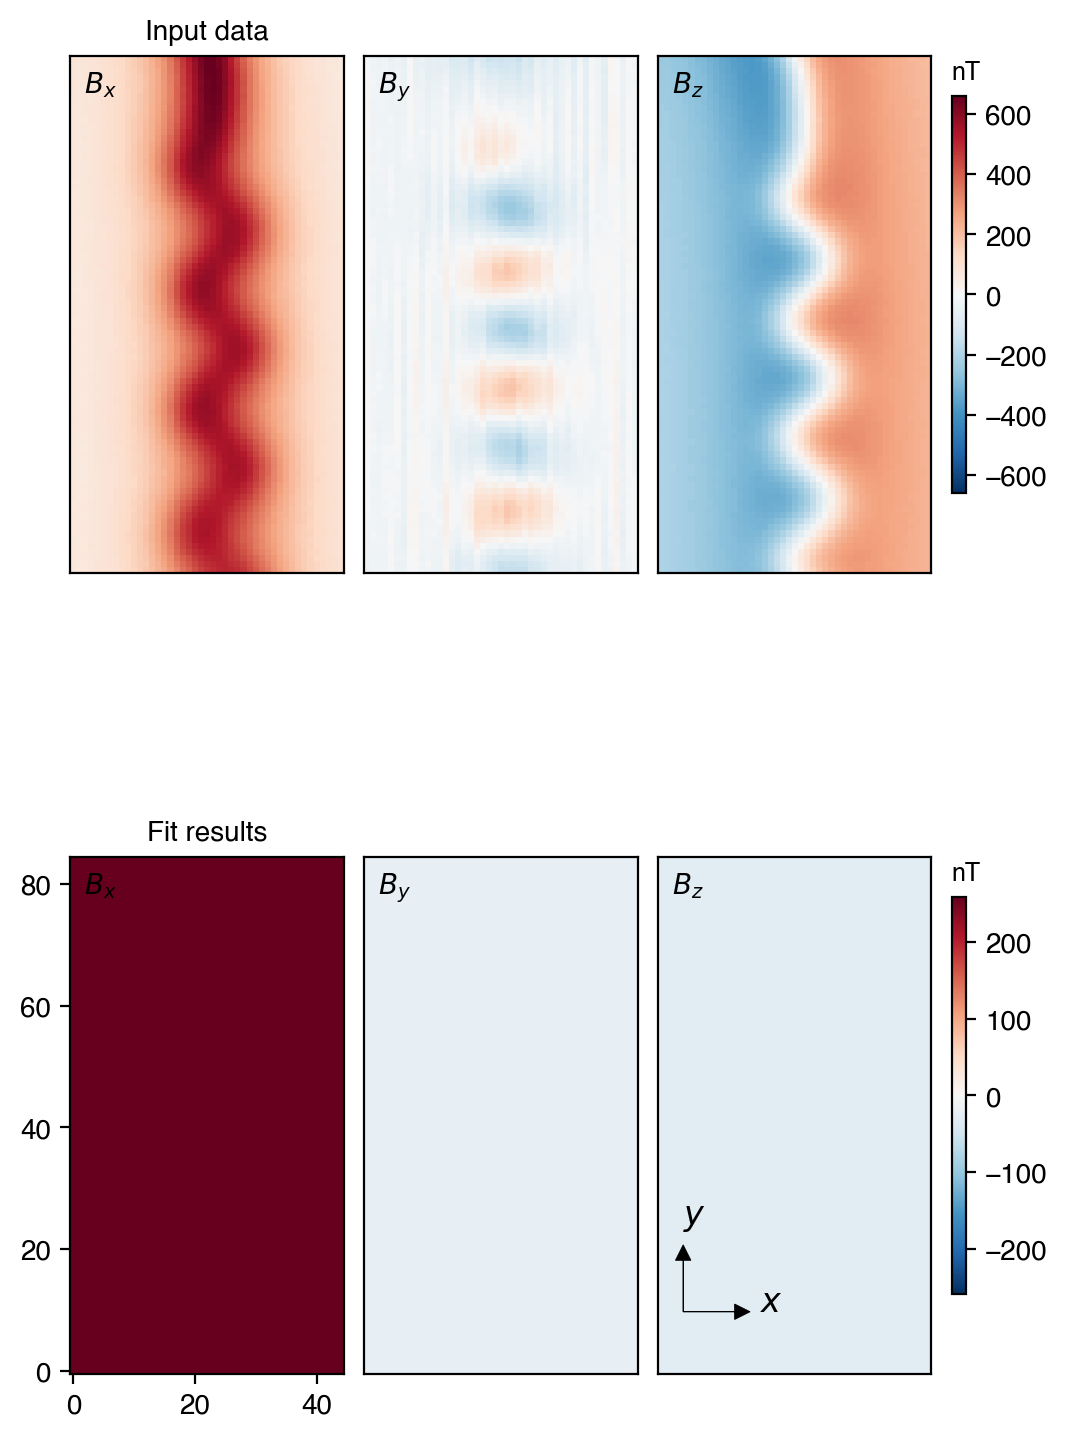

In [25]:
config = JerschowExperimentConfig('Sine_wire.txt',
                                  model_params=dict(n_inputs=3, n_outputs=3, 
                                                    ff_stds=[(4, 20)]),
                                  data_batch_size=1000,
                                  batch_size=1000,
                                  lr=1e-2,
                                  nz_points=100,
                                  eps_curl=1,
                                  eps_data=1,
                                  eps_div=1,)

experiment = JerschowExperimentLearnBRandomPts(config)
experiment.load_data()

experiment.train(n_iters=100000)

experiment.model.is_trained = True
experiment.plot_results()

<Axes: >

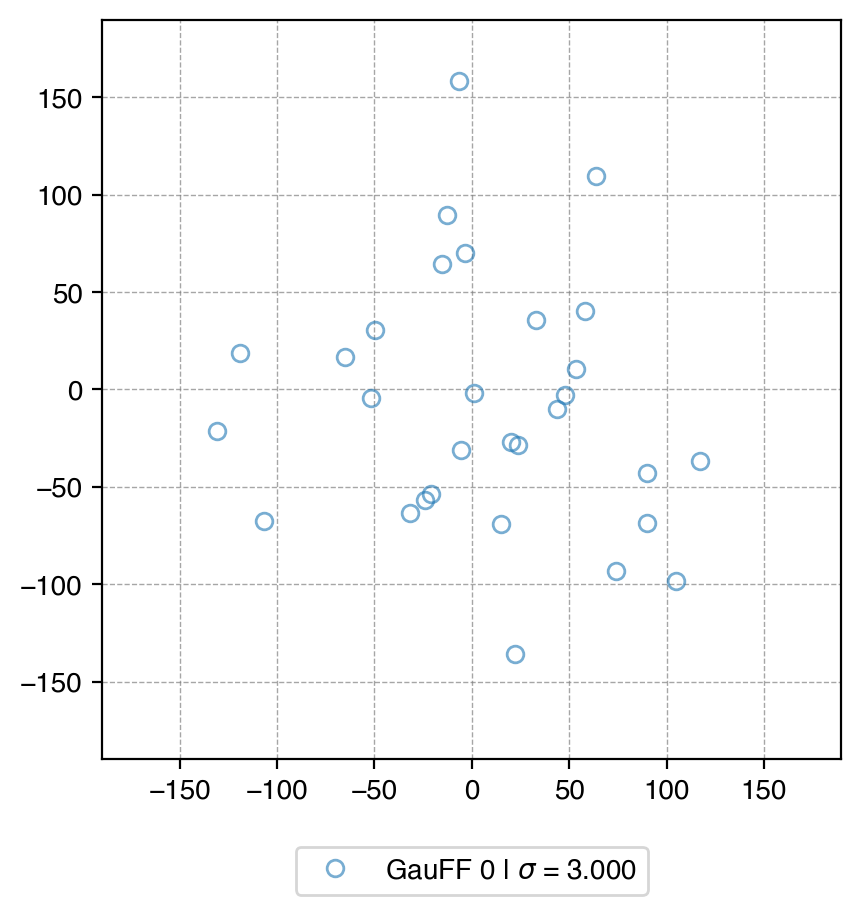

In [30]:
plot_ffs_params(GaussianFourierFeaturesTransform(2, 30, 3))

## Augmenting train loss with extra terms

The idea is to introduce, first, the term that will enfore decaying of the magnetic field outside of the field of view. The rough idea is to extract the values at the boundary of the data and set that as the maximal value of the field outside the field of view. But sort of “less is better”. That should be enforced on `x=0 f.o.v` and `x=1 f.o.v` in relative units (`f.o.v.` is field of view unit, 0 is the beginning of the f.o.v. and 1 is its end). 

I need to create a new class `ExperimentLearnDecayB` and augment the loss function with this new term.

In [18]:
from magrec.misc.data import DataBlock

regions = DataBlock()
regions["original"] = experiment_decay.config.data
regions["original"]["B_norm"] = np.linalg.norm(regions["original"]["B"], axis=1)
regions["all_expanded"] = experiment_decay.config.data.expand_bounds_2d([(1, 1), (1, 1)])
regions["y_expanded"] = regions["original"].expand_bounds_2d([(0, 0), (1, 1)])
regions["sides_expanded"] = (regions["all_expanded"] - regions["y_expanded"])
regions["sides_expanded"].extend_data(source=regions["original"], source_name="B", target_name="B_decay")

cmap = "viridis"

# Get the scalar range from the original data to use the same limits
scalar_range = regions["original"].get_data_range("B_norm")

pl = pv.Plotter()
pl.add_mesh(regions["original"], scalars="B", cmap=cmap, clim=scalar_range, show_scalar_bar=False)
pl.add_mesh(regions["sides_expanded"], scalars="B_decay", cmap=cmap, clim=scalar_range, show_scalar_bar=False)

# Add a single colorbar for both meshes
pl.add_scalar_bar(title="B, mT", n_labels=5)

pl.show()


Widget(value='<iframe src="http://localhost:51269/index.html?ui=P_0x32c8ea1d0_0&reconnect=auto" class="pyvista…

In [50]:
config = JerschowExperimentConfig('Sine_wire.txt',
                                  model_params=dict(n_inputs=3, n_outputs=3, 
                                                    ff_stds=[(0.1, 10), (2, 5), (3, 5)]),
                                  data_batch_size=1000,
                                  batch_size=1000,
                                  decay_batch_size=1000,
                                  lr=1e-2,
                                  nz_points=100,
                                  eps_curl=1e3,
                                  eps_data=1e7,
                                  eps_div=1e7,
                                  eps_decay=10,)

experiment_decay = JerschowExperimentLearnDecayB(config)

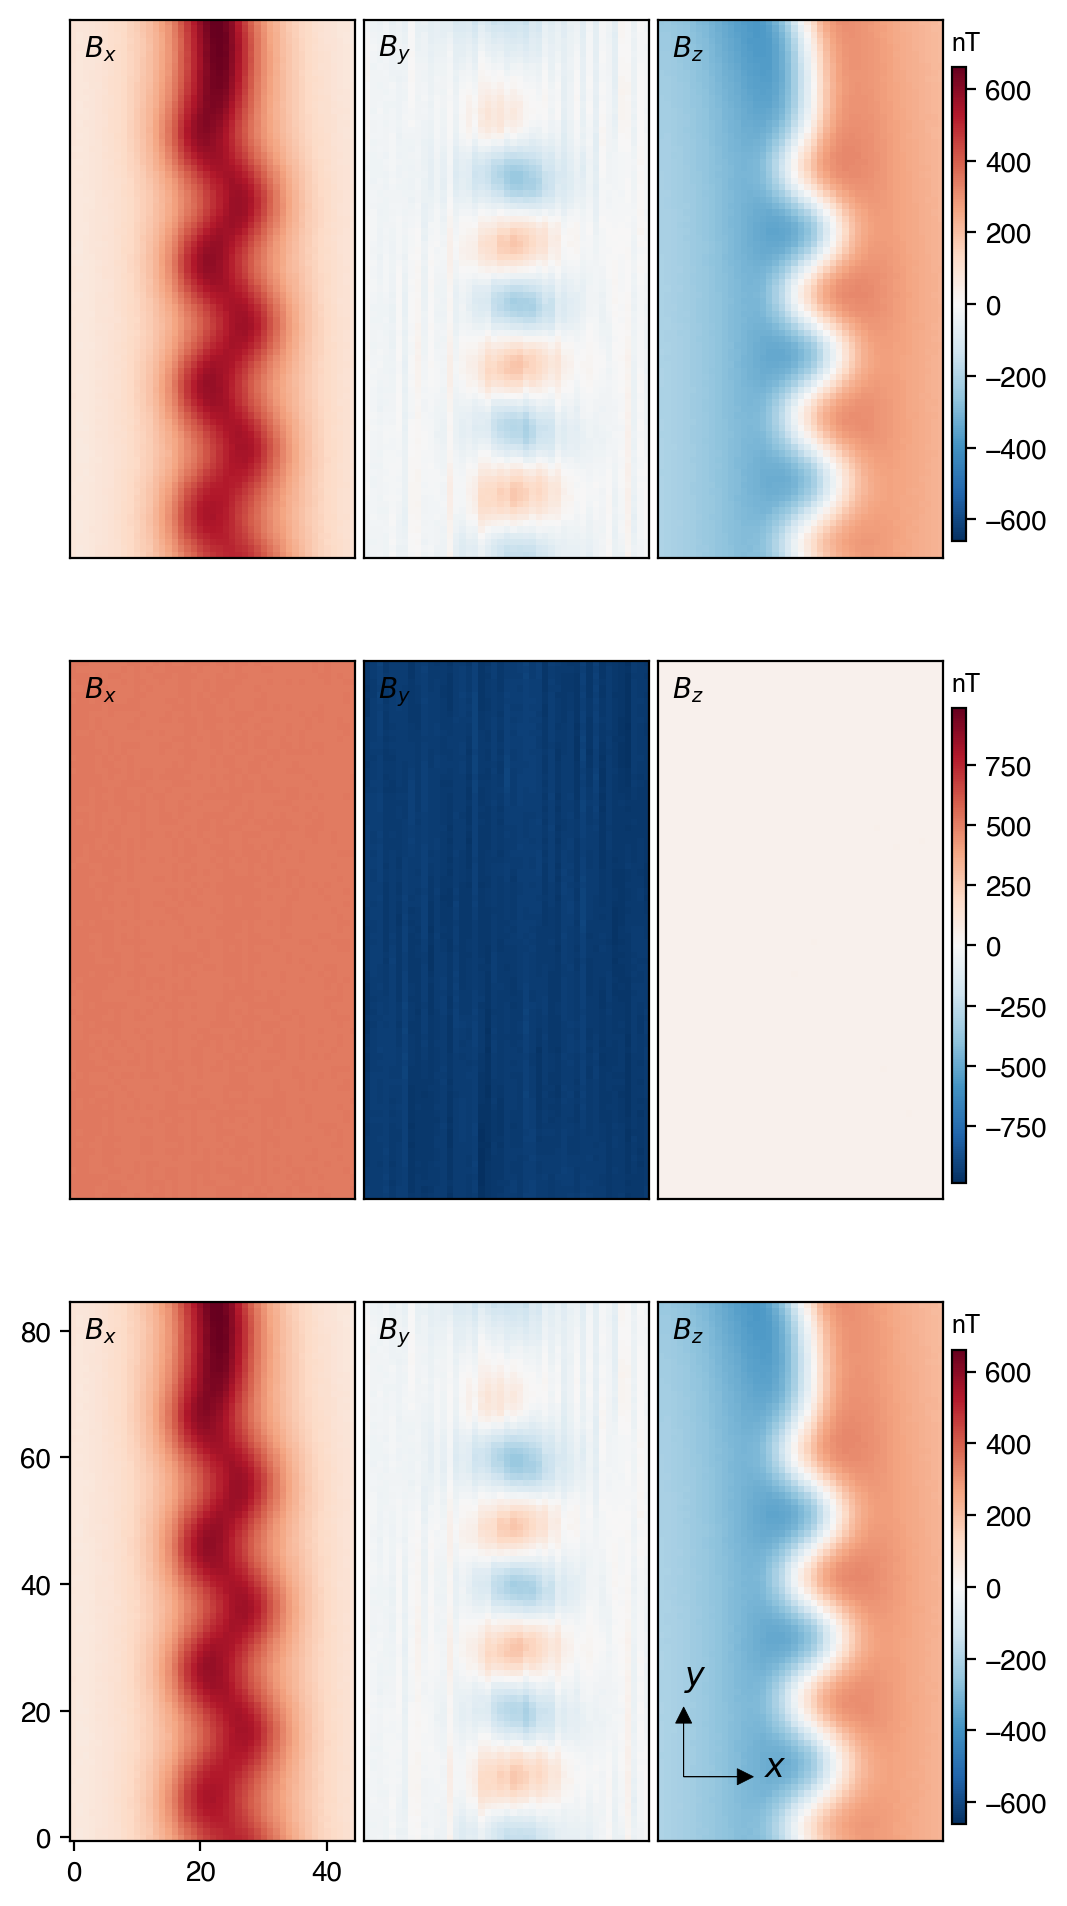

In [51]:
experiment_decay.plot_data()

In [11]:
experiment_decay.train(n_iters=100000)

100%|██████████| 100000/100000 [56:02<00:00, 29.74it/s] 


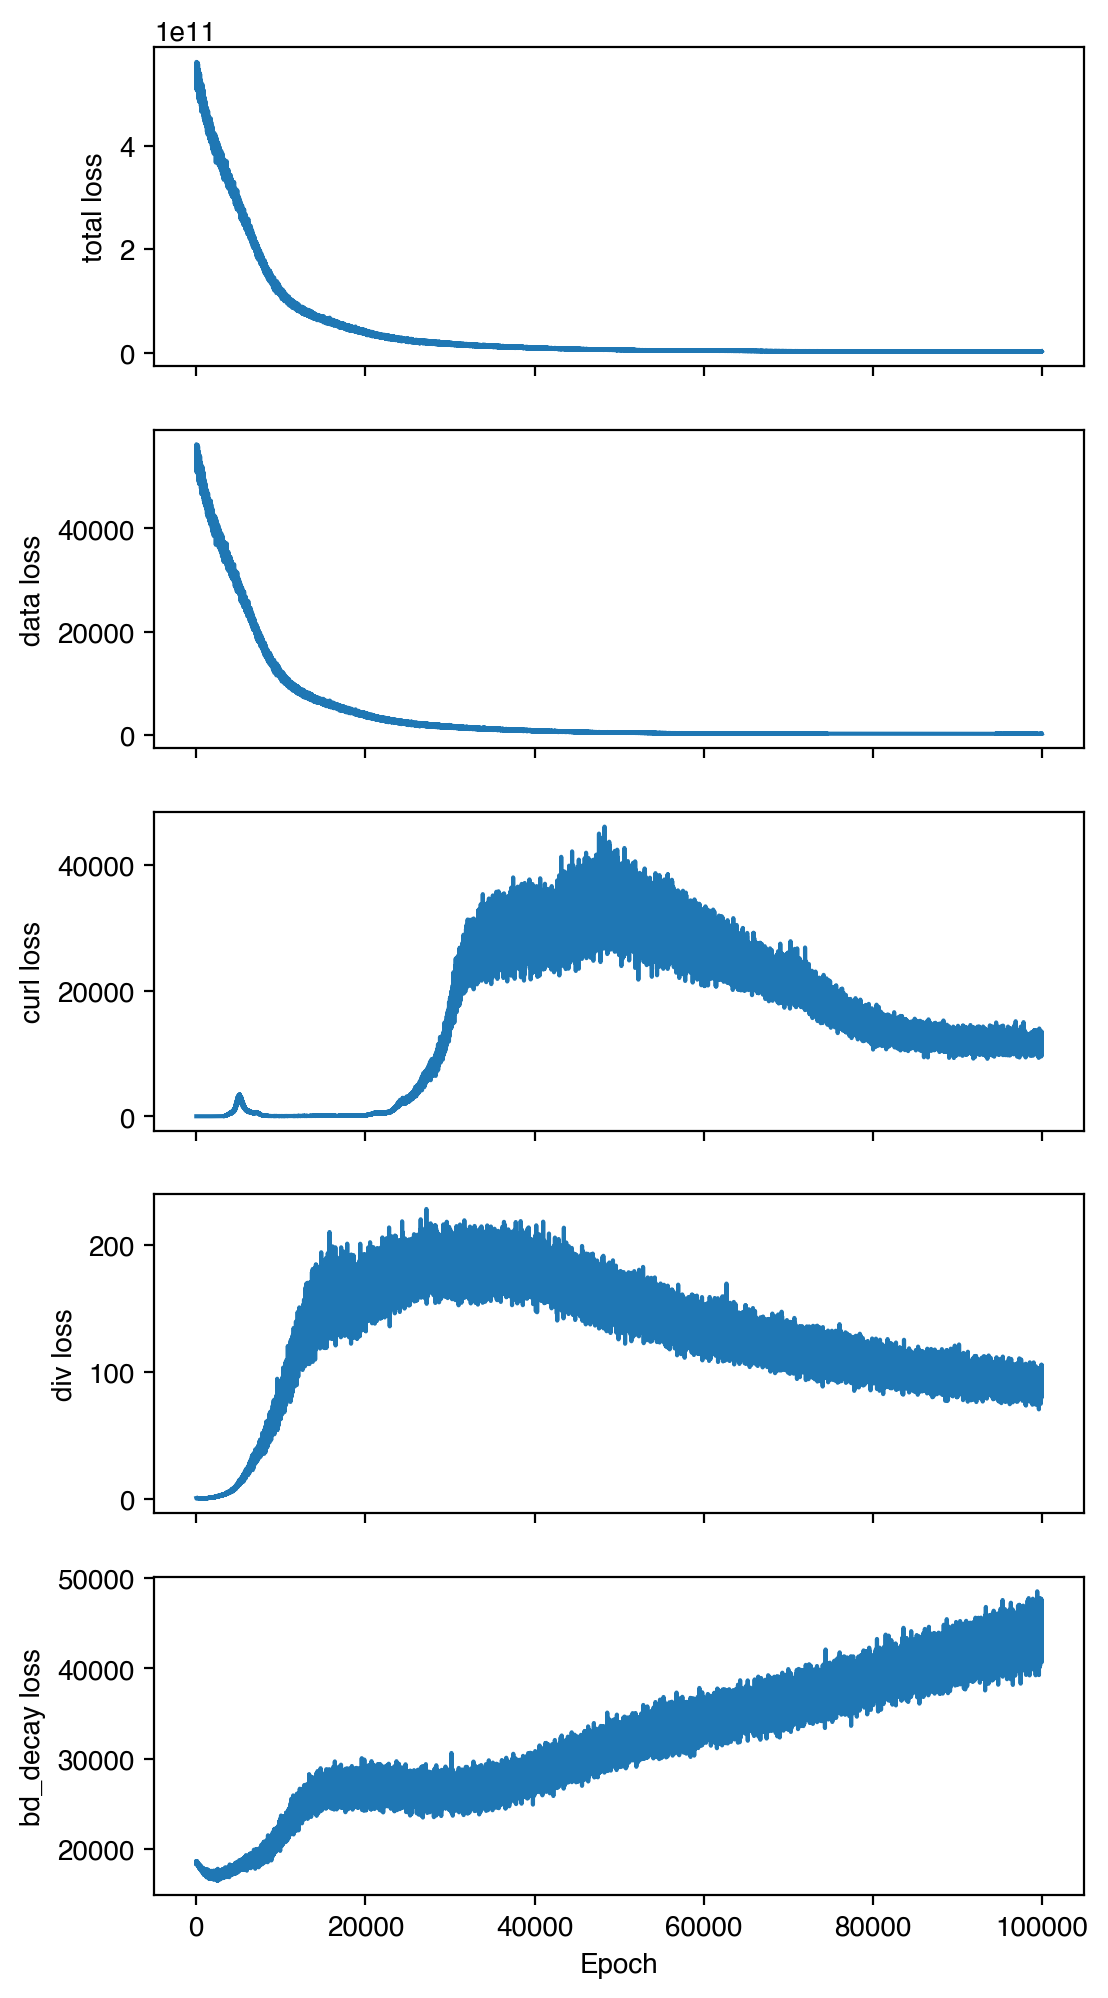

In [14]:
experiment_decay.plot_losses()

In [52]:
# save_model_for_experiment(experiment_decay, __datapath__ / "model_state_dict_decay.pt")
load_model_for_experiment(experiment_decay, __datapath__ / "model_state_dict_decay.pt")

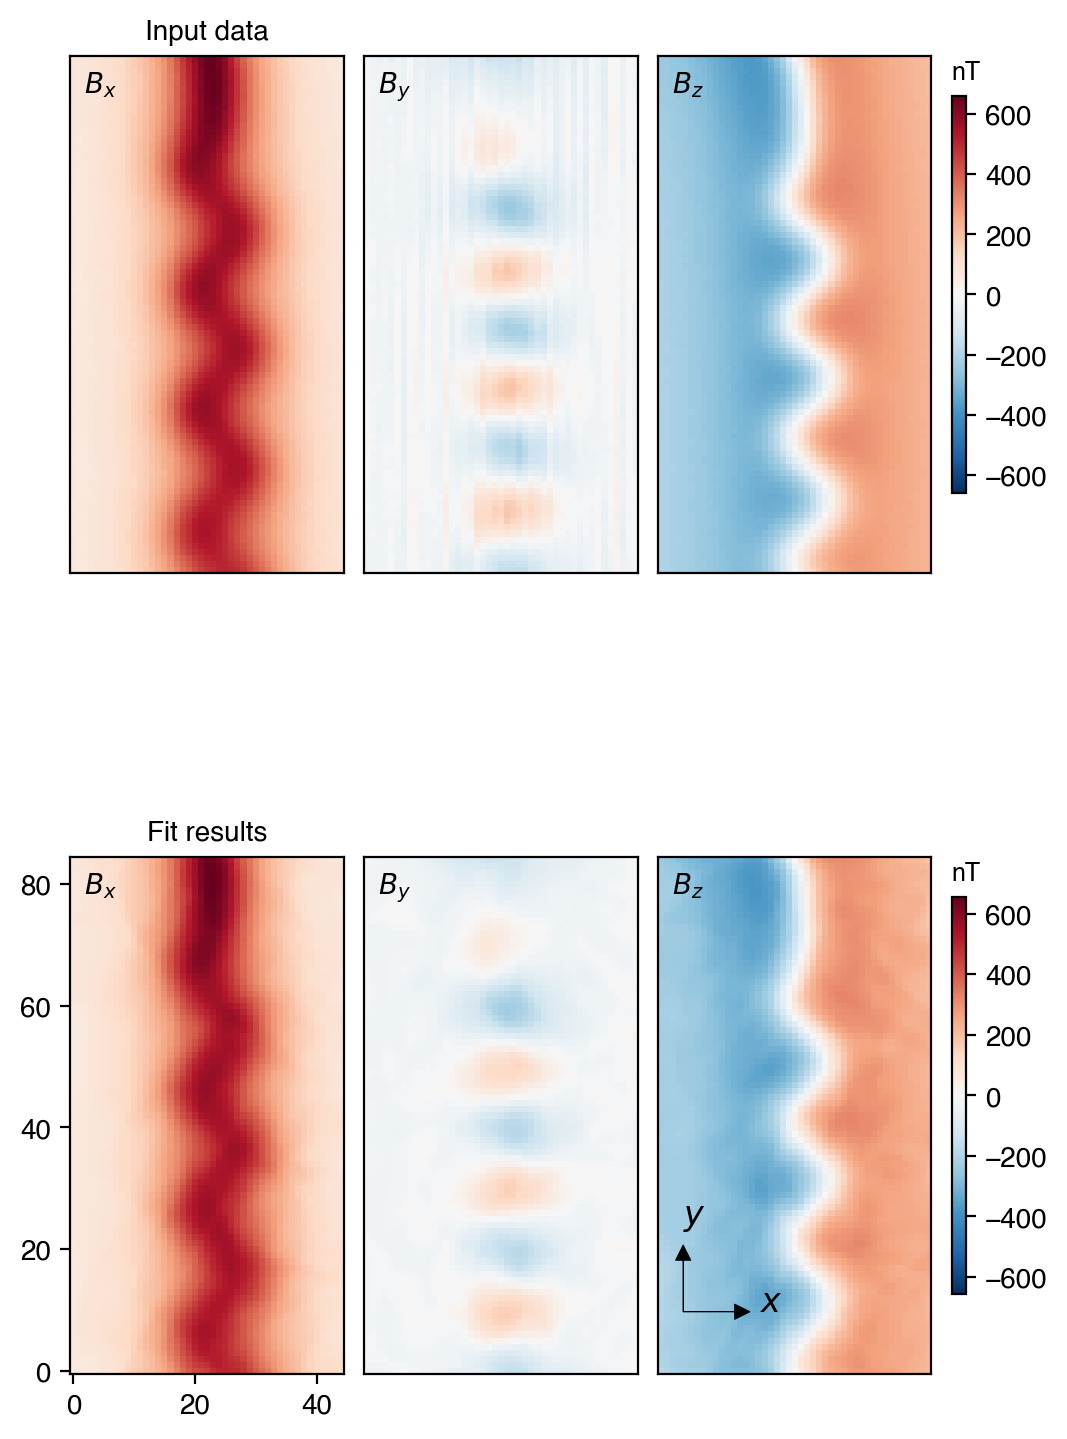

In [15]:
experiment_decay.plot_results()

In [57]:
experiment_decay.losses = experiment_decay._initialize_losses()

In [ ]:
experiment_decay.debug("train", n_iters=10)

100%|██████████| 1000/1000 [00:29<00:00, 34.24it/s]


In [ ]:
experiment.decay.debug_points

In [59]:
experiment_decay.plot_debug_points()

In [19]:
regions["all_expanded"].map(experiment_decay.model, "B_fit")

MagneticFieldImageData (0x3254c0880)
  N Cells:      34036
  N Points:     34425
  X Bounds:     -9.000e+01, 1.780e+02
  Y Bounds:     -1.700e+02, 3.380e+02
  Z Bounds:     0.000e+00, 0.000e+00
  Dimensions:   135, 255, 1
  Spacing:      2.000e+00, 2.000e+00, 1.000e+00
  N Arrays:     1

In [31]:
regions["all_expanded"].map(experiment_decay.model, "B_fit")
regions["all_expanded"].plot(scalars="B_fit")

Widget(value='<iframe src="http://localhost:51269/index.html?ui=P_0x32d9823e0_4&reconnect=auto" class="pyvista…

In [25]:
regions["sides_expanded"].map(experiment_decay.model, "B_fit")

MagneticFieldUnstructuredGrid (0x32ca7e1a0)
  N Cells:    22950
  N Points:   22950
  N Strips:   0
  X Bounds:   -9.000e+01, 1.780e+02
  Y Bounds:   -1.700e+02, 3.380e+02
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   3

In [26]:
regions["sides_expanded"]["decay_fit_diff"] = regions["sides_expanded"]["B_decay"] - regions["sides_expanded"]["B_fit"]

In [27]:
regions["sides_expanded"].plot(scalars="decay_fit_diff")

Widget(value='<iframe src="http://localhost:51269/index.html?ui=P_0x32d983640_3&reconnect=auto" class="pyvista…

In [24]:
regions["sides_expanded"].points[torch.randint(0, len(regions["sides_expanded"].points), (10,))]

pyvista_ndarray([[ -44., -138.,    0.],
                 [ -16.,  334.,    0.],
                 [ -64.,   62.,    0.],
                 [ -32.,  -96.,    0.],
                 [ -54.,  324.,    0.],
                 [ -52.,  -98.,    0.],
                 [ -26.,  156.,    0.],
                 [ 172.,   36.,    0.],
                 [ -58.,  296.,    0.],
                 [ -20., -100.,    0.]])

In [87]:
save_model_for_experiment(experiment_decay, __datapath__ / "model_state_dict_decay.pt")
# experiment_decay = load_model_for_experiment(experiment_decay, __datapath__ / "model_state_dict_decay.pt")

In [88]:
experiment_decay.get_data_sample(10)

(tensor([[ 56.,  30.,   0.],
         [ 52.,  56.,   0.],
         [ 26.,  90.,   0.],
         [ 72.,  20.,   0.],
         [ 12.,  72.,   0.],
         [ 18., 132.,   0.],
         [ 56.,  82.,   0.],
         [ 64., 146.,   0.],
         [ 68.,  12.,   0.],
         [  6.,  14.,   0.]]),
 tensor([[ 530.1274,  -17.5016,  100.2168],
         [ 482.1020,  121.0251,  -10.5639],
         [ 224.0835,   27.4156, -306.2976],
         [ 199.3168,   -8.4456,  263.5396],
         [  92.0504,  -39.8586, -241.5089],
         [ 152.4619,  -35.4386, -284.2863],
         [ 479.9175, -116.5713,  300.7582],
         [ 235.0964,  -35.6099,  293.9310],
         [ 235.1937,  -10.2174,  271.5538],
         [  74.6162,  -30.2697, -219.1281]]))

In [89]:
regions["all_expanded"].points[torch.randint(0, regions["all_expanded"].n_points, (10,))]

array([[ 154.,  -82.,    0.],
       [  34., -132.,    0.],
       [ 106.,  -76.,    0.],
       [ -16., -148.,    0.],
       [ -86.,  102.,    0.],
       [ 168.,   72.,    0.],
       [ -26.,  238.,    0.],
       [ 164.,  204.,    0.],
       [   2.,   60.,    0.],
       [ -42.,  -18.,    0.]])

In [90]:
experiment_decay.get_decay_sample(10)

(tensor([[  -2.,   26.,    0.],
         [ 164., -112.,    0.],
         [ -62.,  124.,    0.],
         [  96.,  282.,    0.],
         [  94.,  -20.,    0.],
         [ -86.,  -22.,    0.],
         [ 176.,  -54.,    0.],
         [ 142., -118.,    0.],
         [ -34., -100.,    0.],
         [ 110.,  236.,    0.]]),
 tensor([[  72.3435,   -6.6432, -206.6759],
         [  95.1291,  -11.2734,  225.8752],
         [  76.1635,  -13.3827, -218.8296],
         [  66.8076,  -11.5411,  206.4657],
         [  95.1291,  -11.2734,  225.8752],
         [  73.5419,  -36.4496, -205.1494],
         [  95.1291,  -11.2734,  225.8752],
         [  95.1291,  -11.2734,  225.8752],
         [  73.5419,  -36.4496, -205.1494],
         [  66.8076,  -11.5411,  206.4657]]))

Really weird. The sampling regions are correct (modulus that they are at the wrong height: for they are all of the wrong height, making them combined at the right height). However, it seems that the decay terms is not enforced enough, leading to the field outside the regions to be not decaying enough. 

We will now try to compare the decay term loss manually, and see if it is indeed too small.

In [91]:
bd_decay_pts, bd_decay_targets = experiment_decay.get_decay_sample(2000)
bd_decay_vals = experiment_decay.model(bd_decay_pts)
bd_decay_loss = experiment_decay.loss_fn(torch.clamp(bd_decay_vals - bd_decay_targets, min=0) ** 2, torch.zeros_like(bd_decay_vals))
print(bd_decay_loss)

tensor(0.5512, grad_fn=<MseLossBackward0>)


## Denoising data

Let's see if the approach above works for denoising data. I have observed that the original dataset had systematic noise, and after reconstruction it was removed. Let's test adding more noise to the dataset and observing if the model can denoise it.

In [15]:
class JerschowExperimentDenoise(JerschowExperimentLearnBRandomPts):  # names become like in Java now
    def __init__(self, config, noise_level=0.1):
        super().__init__(config)
        self.noise_level = noise_level
        self.is_trained = False

    def load_data(self):
        super().load_data()
        self.config.data["B_noisy"] = self.data_vals + self.noise_level * torch.randn_like(self.data_vals)
        self.data_vals = torch.tensor(self.config.data["B_noisy"], dtype=torch.float)
        
    def plot_results(self):
        """Plot the results of the experiment."""
        self.model.eval()
        res_vals = self.model(self.data_pts).detach().cpu().numpy()
        self.config.data["B_fit"] = res_vals  # Store the fit results in the data object
        # This ensures that the order of data values and space points matches 
        res_vals = self.config.data.get_as_grid("B_fit")
        data_vals = self.config.data.get_as_grid("B")
        noisy_data_vals = self.config.data.get_as_grid("B_noisy")
        fig = plot_n_components(
            [data_vals, noisy_data_vals, res_vals], 
            title=["Input data", "Noisy data", "Fit results"],
            labels=[r"$B_x$", r"$B_y$", r"$B_z$"], 
            cmap="RdBu_r", 
            units=r"{}".format(self.config.units["magnetic_field"]))
        
        return fig

In [16]:
config.data

In [17]:
experiment_denoise = JerschowExperimentDenoise(config, noise_level=20)
experiment_denoise.load_data()
experiment_denoise.config.data.plot(scalars="B_noisy")

Widget(value='<iframe src="http://localhost:53784/index.html?ui=P_0x31eddee60_0&reconnect=auto" class="pyvista…

In [22]:
experiment_denoise.train(n_iters=100000)

100%|██████████| 100000/100000 [30:14<00:00, 55.13it/s] 


In [24]:
save_model_for_experiment(experiment_denoise, __datapath__ / 'model_state_dict_GauFF_denoise.pt')
# load_model_for_experiment(experiment_denoise, __datapath__ / 'model_state_dict_GauFF_denoise.pt')

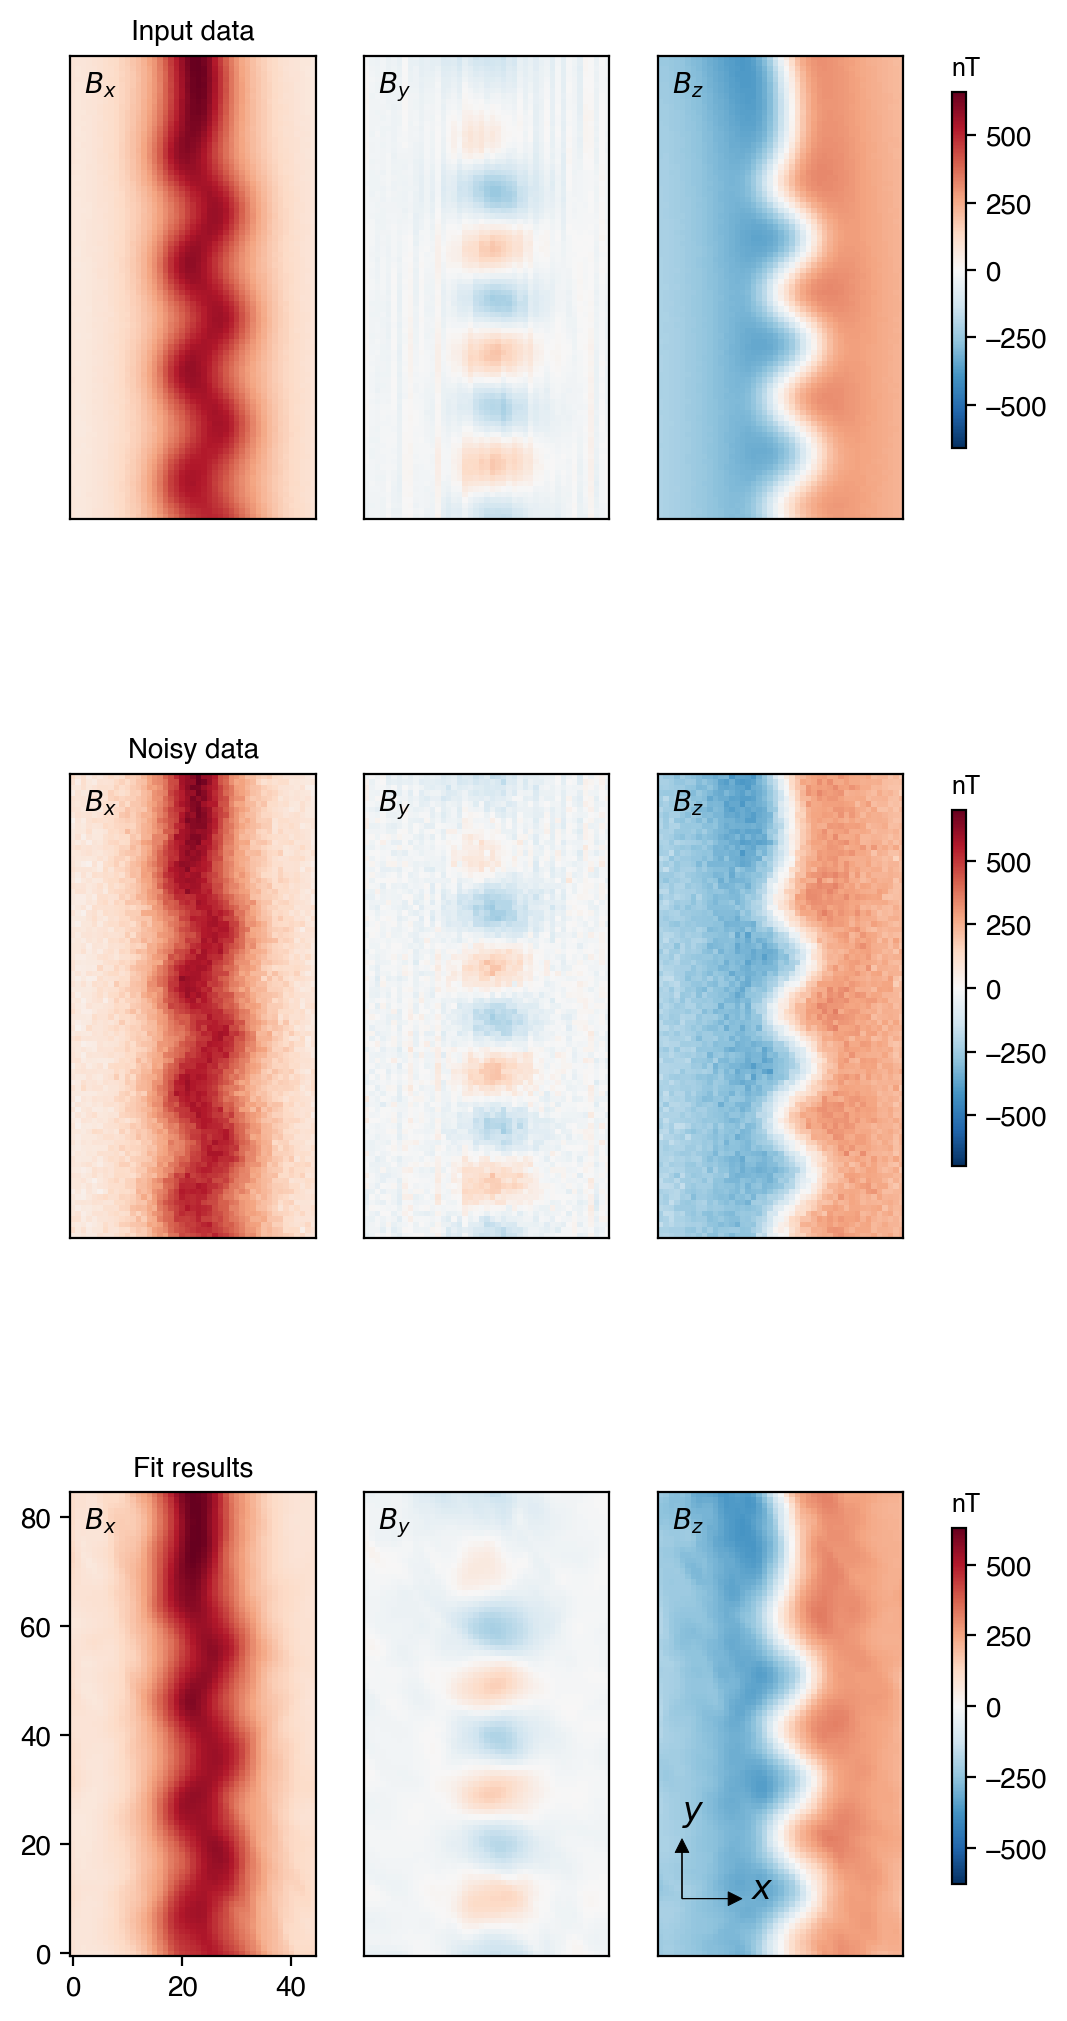

In [25]:
experiment_denoise.plot_results()

The above result is promising. Let's try with even more noise.

In [26]:
experiment_denoise = JerschowExperimentDenoise(config, noise_level=100)
experiment_denoise.load_data()
experiment_denoise.config.data.plot(scalars="B_noisy")

Widget(value='<iframe src="http://localhost:53784/index.html?ui=P_0x34c6f1990_1&reconnect=auto" class="pyvista…

In [27]:
experiment_denoise.train(n_iters=100000)

100%|██████████| 100000/100000 [31:53<00:00, 52.27it/s] 


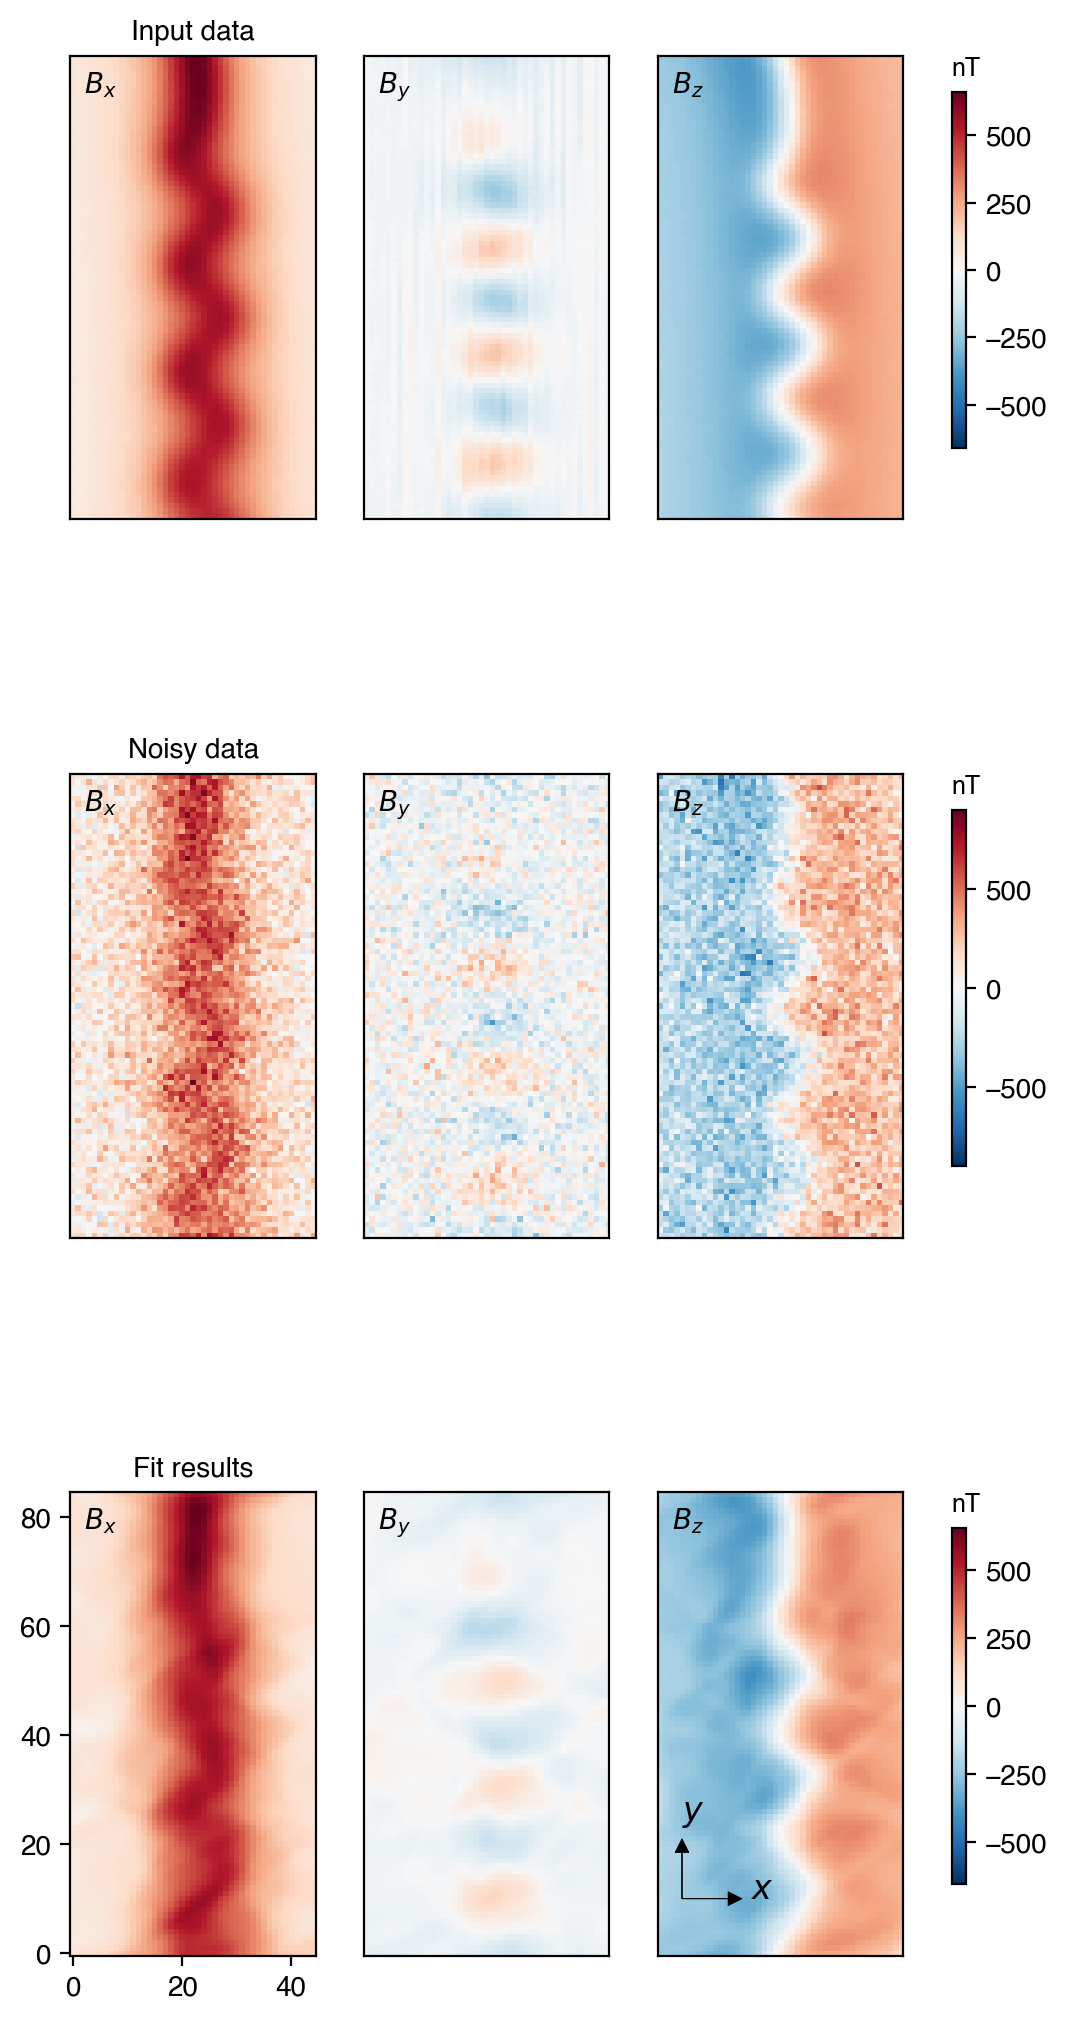

In [28]:
experiment_denoise.plot_results()

Let's compare it with just smoothening the data. 
1. Applying a Gaussian filter to the data.
2. Applying a median filter to the data.

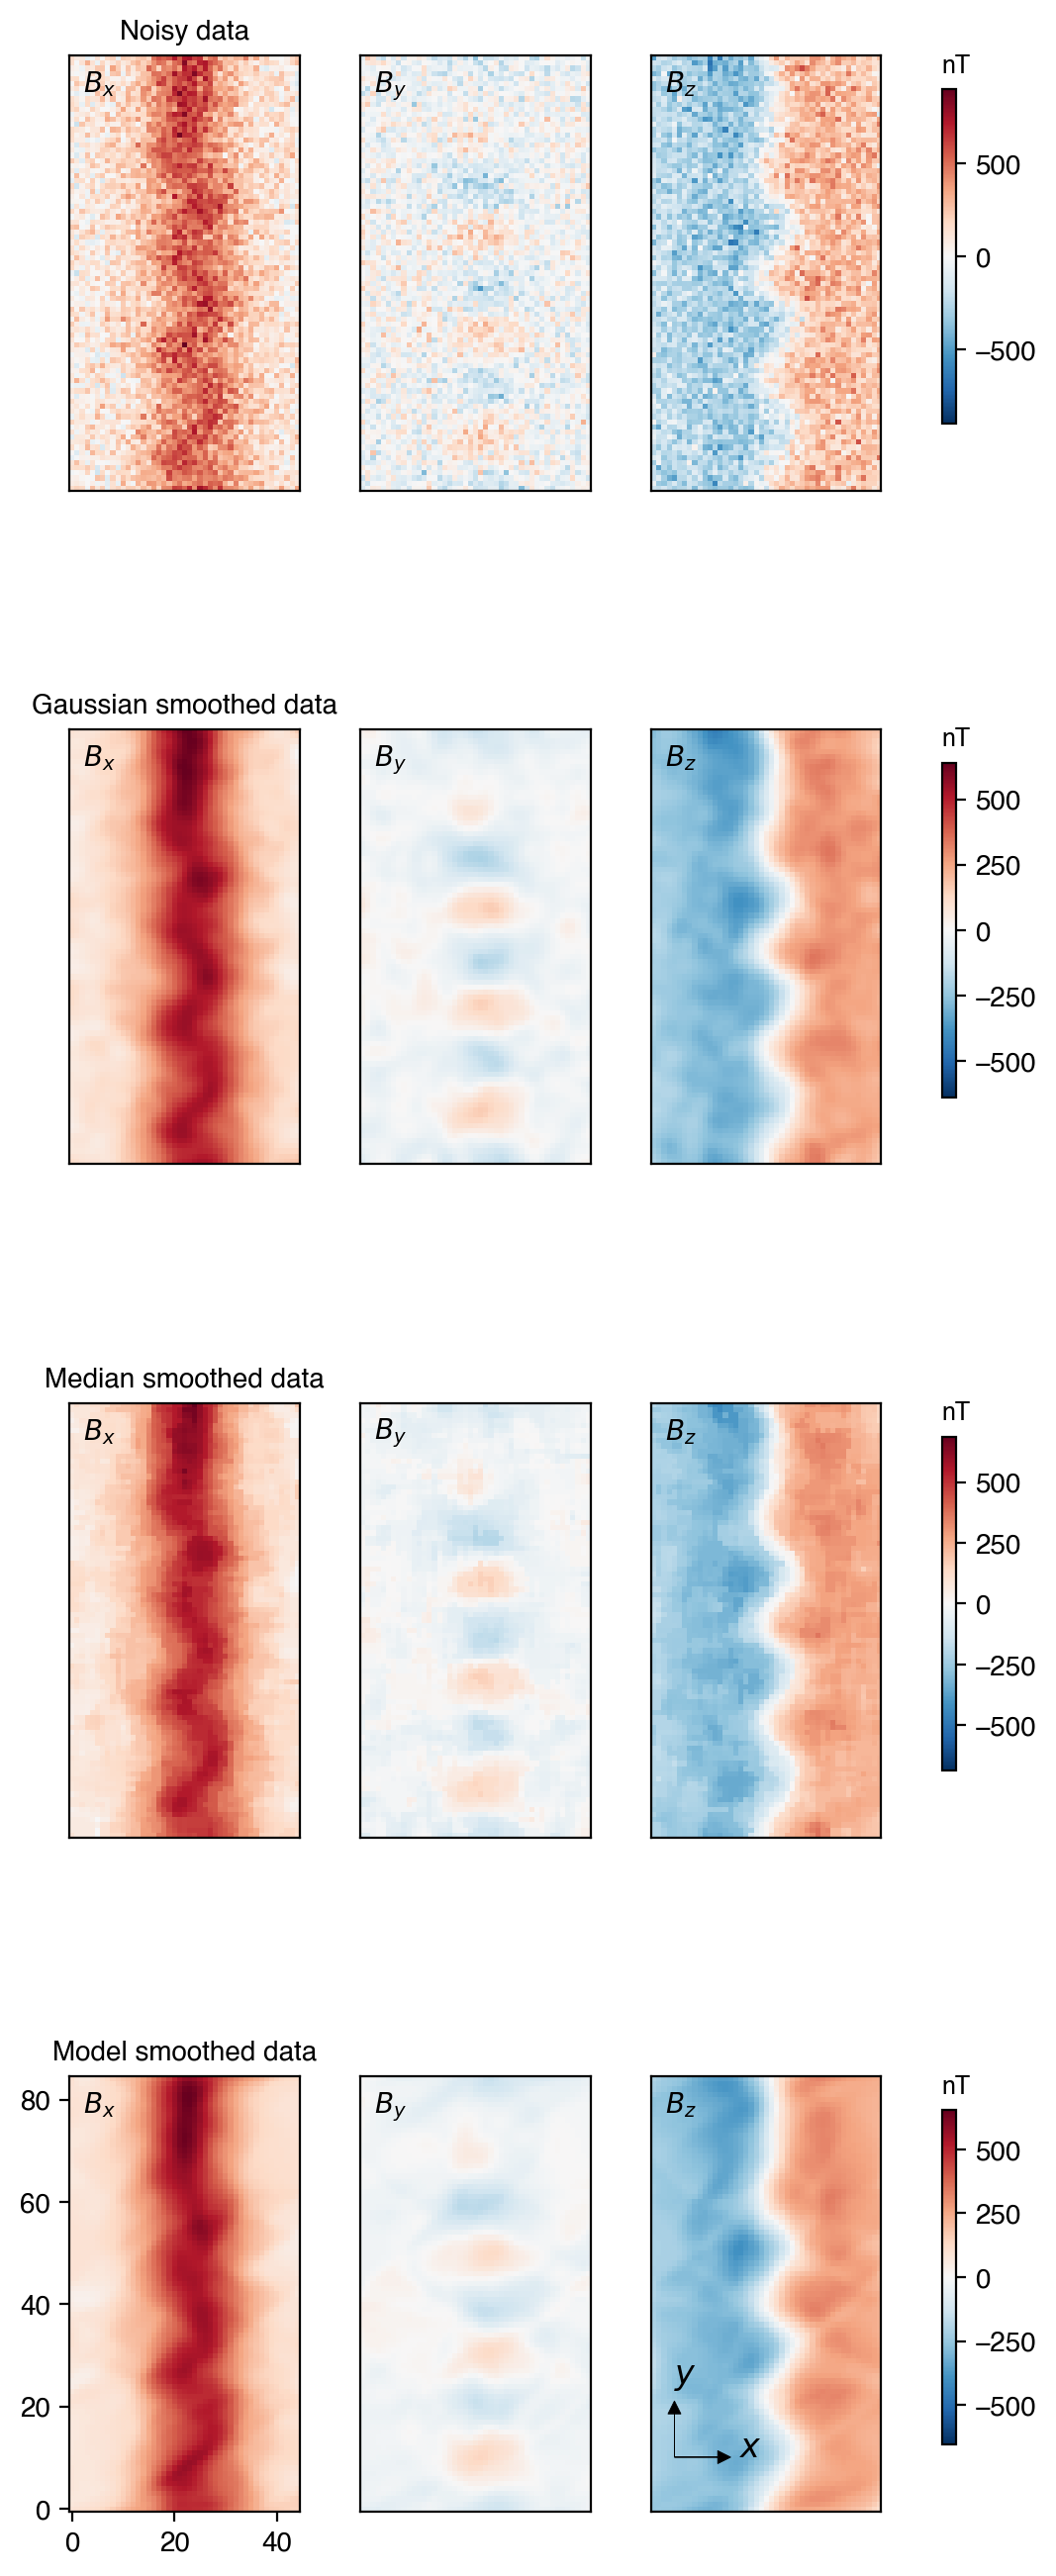

In [39]:
from scipy.ndimage import gaussian_filter, median_filter

# Extract the noisy data
noisy_data = experiment_denoise.config.data.get_as_grid("B_noisy")

# Apply Gaussian filter
gaussian_smoothed_data = gaussian_filter(noisy_data, sigma=1.5, axes=(1,2))

# Apply median filter
median_smoothed_data = median_filter(noisy_data, size=5, axes=(1,2))

model_smoothed_data = experiment.config.data.get_as_grid("B_fit")

# Plot the results
fig = plot_n_components(
    [noisy_data, gaussian_smoothed_data, median_smoothed_data, model_smoothed_data], 
    title=["Noisy data", "Gaussian smoothed data", "Median smoothed data", "Model smoothed data"],
    labels=[r"$B_x$", r"$B_y$", r"$B_z$"], 
    cmap="RdBu_r", 
    units=r"{}".format(experiment_denoise.config.units["magnetic_field"])
)
fig

In [41]:
experiment_denoise = JerschowExperimentDenoise(config, noise_level=200)
experiment_denoise.load_data()
experiment_denoise.config.data.plot(scalars="B_noisy")

Widget(value='<iframe src="http://localhost:53784/index.html?ui=P_0x357ca39a0_3&reconnect=auto" class="pyvista…

In [42]:
experiment_denoise.train(n_iters=100000)

100%|██████████| 100000/100000 [30:09<00:00, 55.28it/s] 


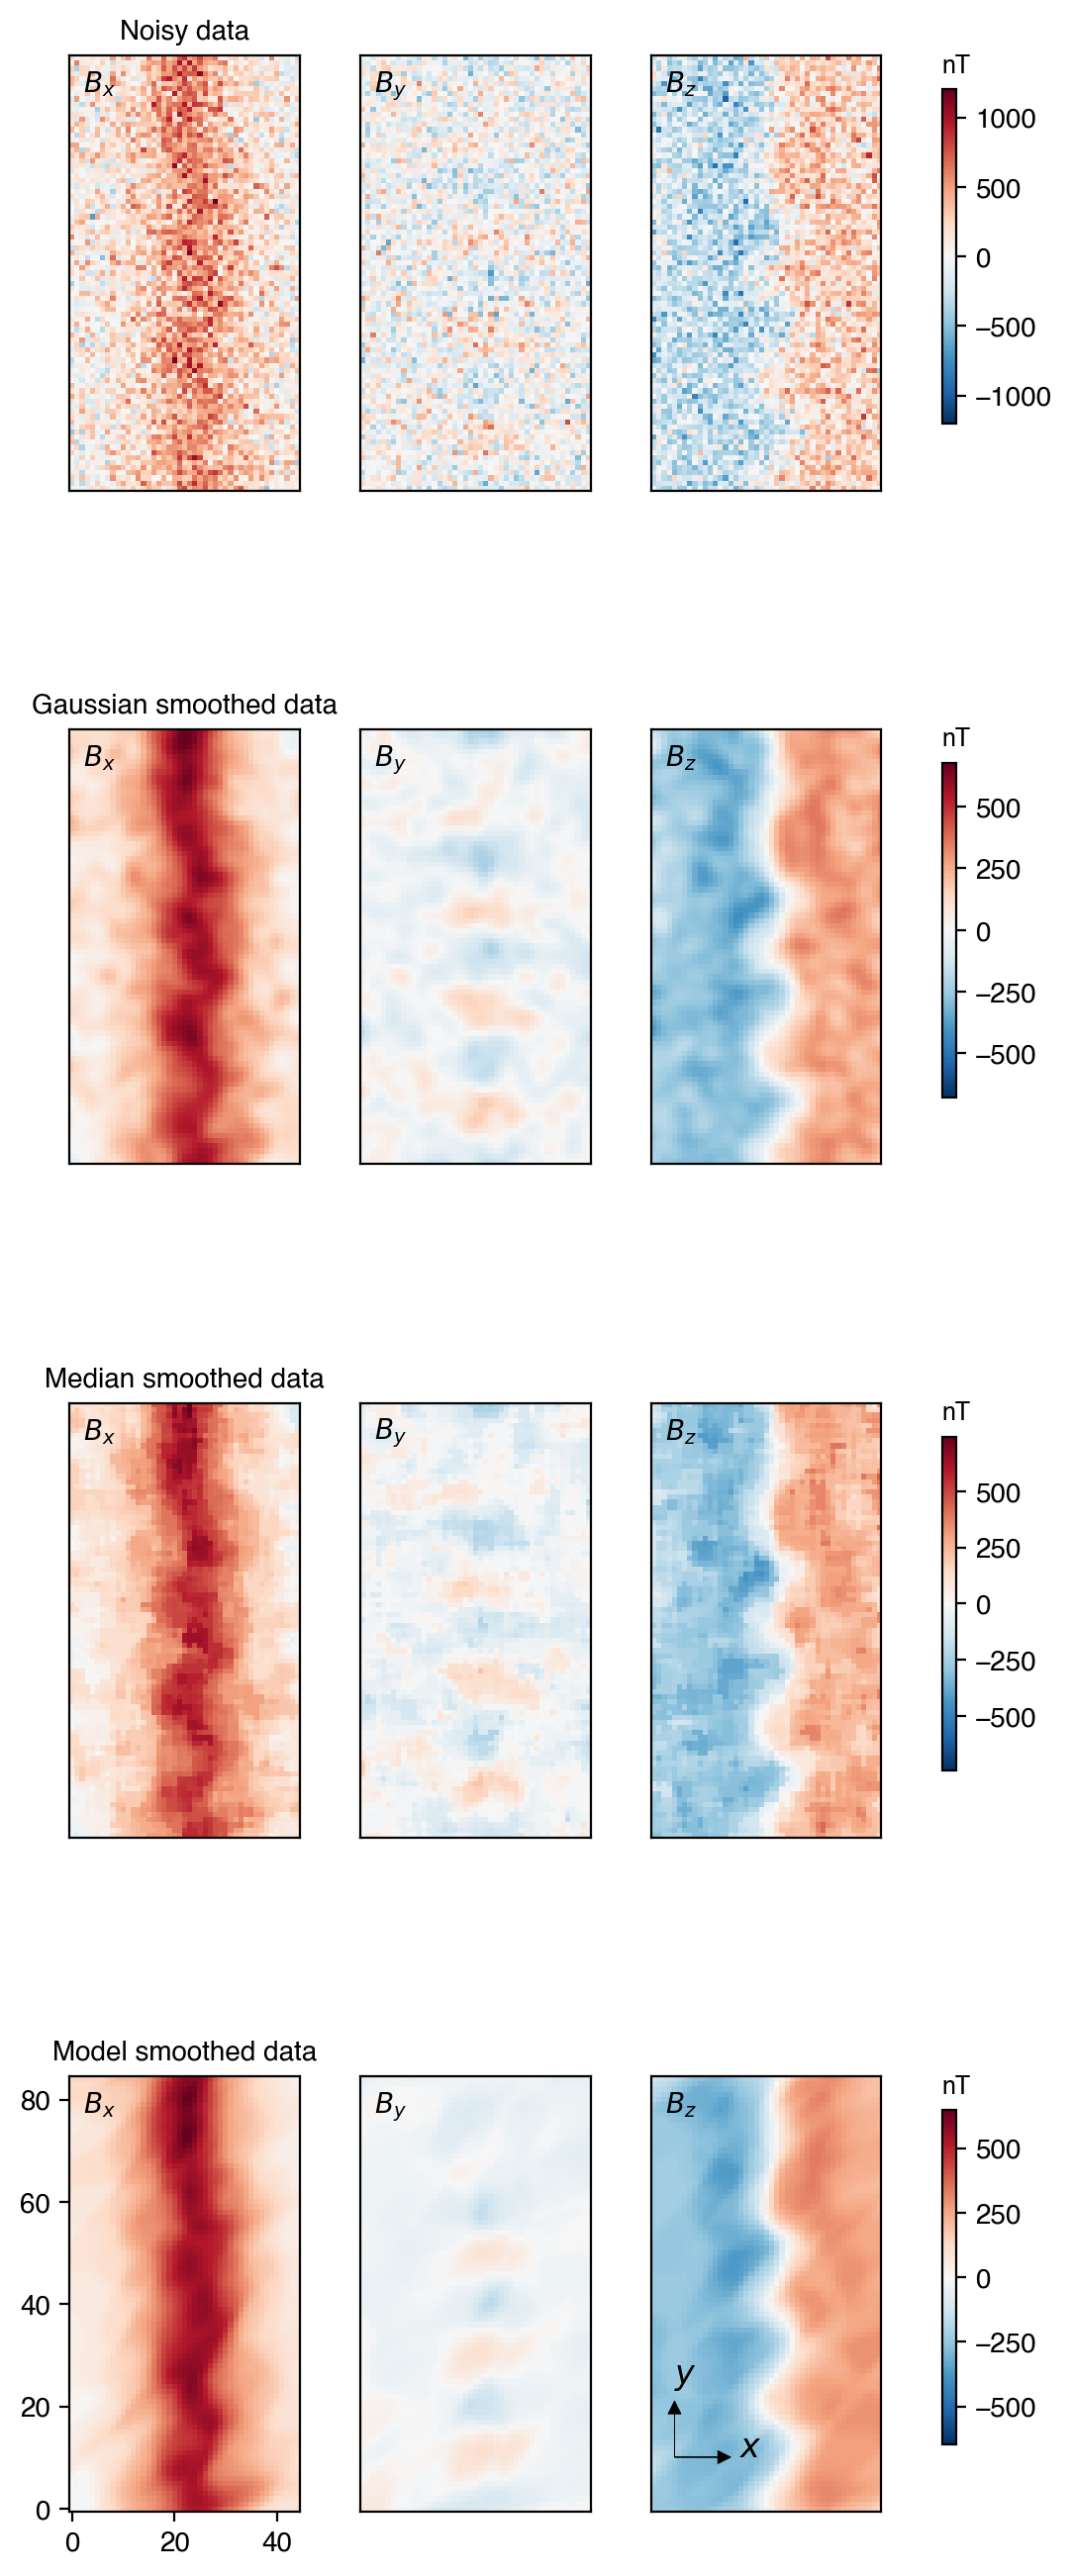

In [44]:
from scipy.ndimage import gaussian_filter, median_filter

experiment_denoise.config.data.map(experiment_denoise.model, "B_fit")

# Extract the noisy data
noisy_data = experiment_denoise.config.data.get_as_grid("B_noisy")

# Apply Gaussian filter
gaussian_smoothed_data = gaussian_filter(noisy_data, sigma=1.5, axes=(1,2))

# Apply median filter
median_smoothed_data = median_filter(noisy_data, size=5, axes=(1,2))

model_smoothed_data = experiment.config.data.get_as_grid("B_fit")

# Plot the results
fig = plot_n_components(
    [noisy_data, gaussian_smoothed_data, median_smoothed_data, model_smoothed_data], 
    title=["Noisy data", "Gaussian smoothed data", "Median smoothed data", "Model smoothed data"],
    labels=[r"$B_x$", r"$B_y$", r"$B_z$"], 
    cmap="RdBu_r", 
    units=r"{}".format(experiment_denoise.config.units["magnetic_field"])
)
fig

It's a promising direction! I see data being better smoothened (noise better accounted for) when introducing the physical constaints. 

Now I want to see if I can enforce really the decay conditions. What do I need to do for that? 

# Jerschow — Learn magnetic potential

Goal of this section is to make a neural network $u_{NN}(x, y, z) = {\Phi}(x, y, z)$ that learns parameters given a set of measurement $N$ values $\{B^i_{NV}\}_{i = 1, \dots, N}$ obtained for a single component of the magnetic field $B_{NV}$ at different points ${(x_i, y_i)}_{i = 1, \dots, N}$ such that $\vec{B} = \nabla \Phi$.

In [ ]:
class JerschowExperimentLearnPot(JerschowExperiment):
    def __init__(self, config):
        super().__init__(config)
        # define extra loss terms to track                                                         
        self.losses = {
            "total": [],
            "data": [],
            "curl": [],
            "div": [],
        }
        
    def load_data(self):
        # Define extra data points for curl and div calculations used in this experiment
        super().load_data()
        
    def get_data_sample(self, n):
        """Returns a tensor of shape (n, l) with n batched samples from an
        l-d space where data is available."""
        list_of_indices = torch.randint(low=0, high=len(self.data_pts), size=(n,))
        return self.data_pts[list_of_indices], self.data_vals[list_of_indices]
    
    def get_B(self, pts: torch.Tensor):
        """The magnetic field B is obtained by applying the gradient to the output of the model."""
        pts.requires_grad = True
        # compute grad of y wrto inputs (pts) at pts
        return batched_grad(self.model)(pts)
    
    
    def train(self, n_iters=1000, **kwargs):
        data_batch_size = self.config.data_batch_size
    
        if "lr" in kwargs:
            self.optimizer.lr = kwargs["lr"]
        
        try:
            self.model.train()
            for i in tqdm.trange(n_iters):
                # Implement the training loop specific to Jerschow Experiment
                # sample data points 
                train_pts, data_targets = self.get_data_sample(n=data_batch_size)
                
                data_est = self.get_B(train_pts)
                data_loss = self.loss_fn(data_est, data_targets)
                
                loss = data_loss
                self.losses["data"].append(data_loss.item())
                
                loss.backward()
                self.optimizer.step()
                # zero the gradients
                self.optimizer.zero_grad()
        except KeyboardInterrupt:
            print("Training interrupted. Safely closing the experiment.")
            self.model.is_trained = True
            self.model.eval()
            
        return self

In [90]:
pot_config = JerschowExperimentConfig('Sine_wire.txt',
                                  data_batch_size=1000,
                                  batch_size=1000,
                                  lr=1e-3,)

pot_config.model = torch.nn.Sequential(
    torch.nn.Linear(3, 10),
    torch.nn.Sigmoid(),
    torch.nn.Linear(10, 10),
    torch.nn.Sigmoid(),
    torch.nn.Linear(10, 1),
)

In [ ]:
pot_experiment = JerschowExperimentLearnPot(pot_config)
pot_experiment.load_data()
pot_experiment.train(n_iters=100000)

  0%|          | 0/100000 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/currec/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1000, 3])) that is different to the input size (torch.Size([1000, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|▏         | 1439/100000 [00:06<07:52, 208.70it/s]


KeyboardInterrupt: 

: 

# Wire — Reconstruct path with the neural network

In [ ]:
def test_path(s):
    r = torch.cat([s, torch.sin(30*s)], dim=1)
    r = rotate_vector_field_2d(r, 45 / 360 * 2 * torch.pi)
    return r

net = WireNet()


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/currec/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name | Type     | Params
----------------------------------
0 | net  | WirePath | 992   
----------------------------------
992       Trainable params
0         Non-trainable params
992       Total params
0.004     Total estimated model params size (MB)
/opt/homebrew/Caskroom/miniconda/base/envs/currec/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [ ]:
net.fit_to_path(test_path, n_points=200, max_epochs=40)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type     | Params
----------------------------------
0 | net  | WirePath | 992   
----------------------------------
992       Trainable params
0         Non-trainable params
992       Total params
0.004     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


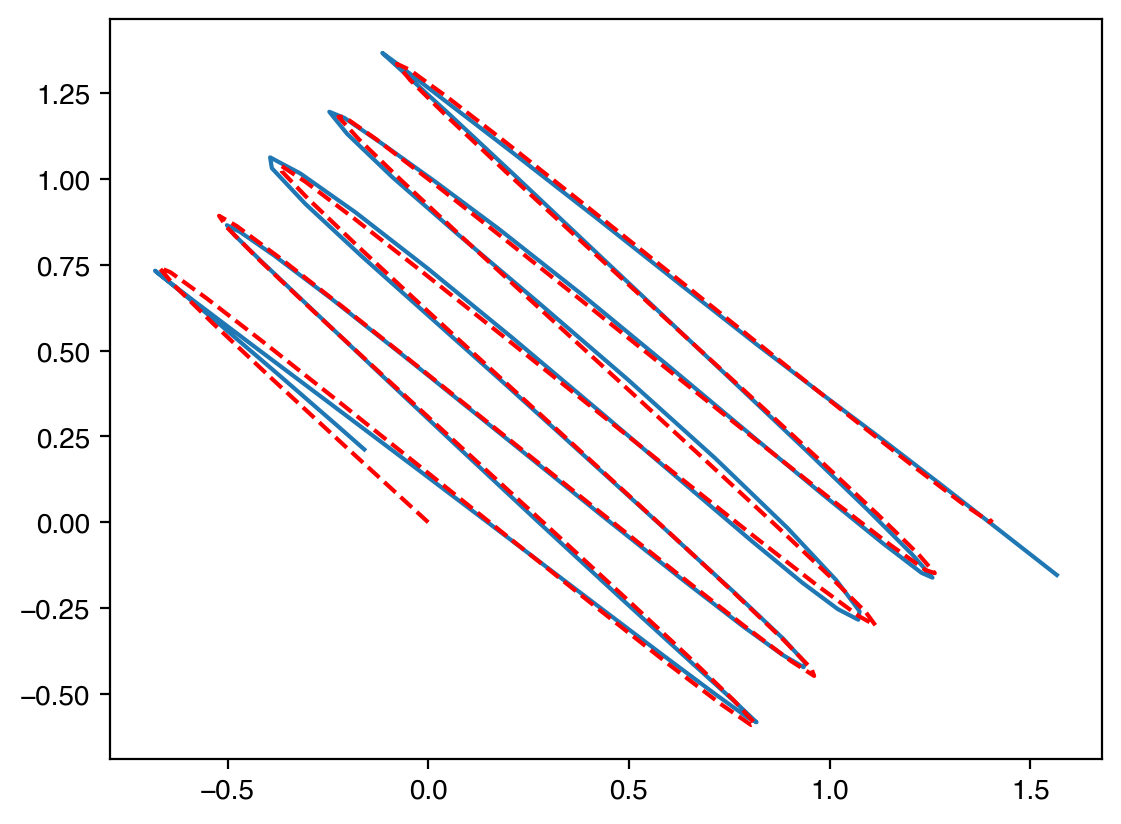

In [ ]:
net.plot_wire()

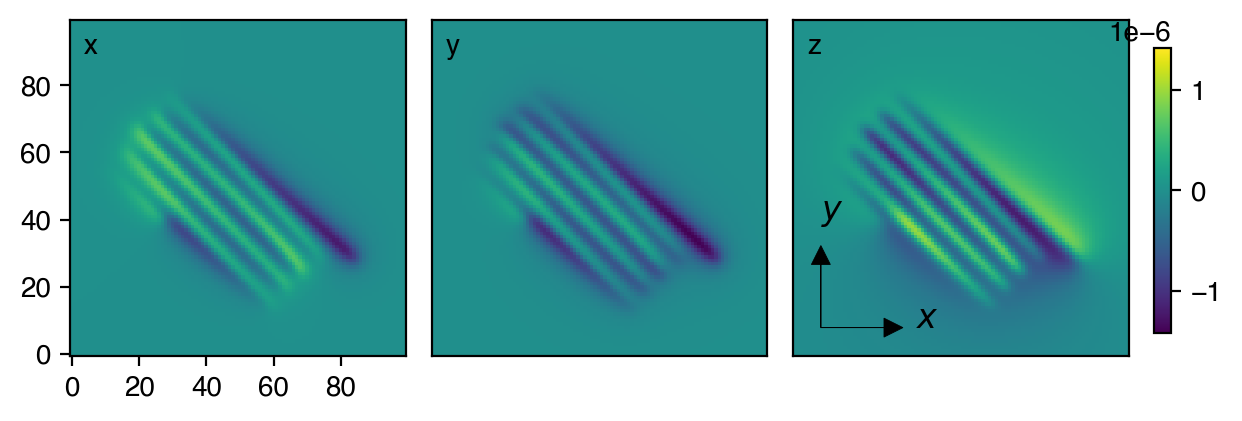

In [ ]:
net.net.I = 1
plane_pos = GridSampler.sample_grid(100, 100, origin=[-1, -1], diagonal=[2, 2], z=0.1)
plane_pos = plane_pos.numpy()

B = net.get_B(pos=plane_pos)
B = GridSampler.pts_to_grid(B, 100, 100)

plot_n_components(B)

# Questions



Where to put `ExperimentConfig` class and `JerschowExperiment`? 

Where to put plotting function to visualize loaded data, which is load function specific?